In [1]:
##Author: Kushin Mukherjee

I recommend running this notebook inside a conda environment to keep things organized and for reproducibility.

Download and install conda: https://docs.conda.io/projects/conda/en/latest/user-guide/install/  
Creating an environment: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

Some tips for installing packages:
First, activate your environment then install pip within the environment so that all the packages you install don't get installed to your global path. To do so:  
Type `conda install pip` in your terminal

Then, when in the project directory:  
Type `pip install -r requirements.txt`


We're using python 3 plus the latest versions of all the packages listed below. Be sure to update before running this nb

In [2]:
### import packages

import sys
import random
import scipy
from importlib import reload
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import clear_output
import svgpathtools
import os.path
from collections import Counter
import svg_rendering_helpers as srh
import statsmodels.api as sm



#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


from skimage import draw   #To create shape arrays
import cv2 #various computer vision tools
import math
from scipy.spatial.distance import cdist, cosine # distance metrics
from scipy.optimize import linear_sum_assignment # optimization functions

### Reading in raw sketch dataset and preparing our stimulus set for NEXT

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
code_dir = os.getcwd()
plot_dir = os.path.join(proj_dir,'plots')
data_dir = os.path.join(proj_dir,'data')


if not os.path.exists(code_dir):
    os.makedirs(code_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# if svg_rendering_helpers.py not in sys.path:
#     sys.path.append(os.path.join(proj_dir,svg_rendering_helpers.py)) 

In [4]:
D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))

In [5]:
def listify(string):
    split_list = string.split("'")
    l=[", u","[u","]"]
    out = [x for x in split_list if x not in l]
    return(out)
    

In [6]:
### Some string manipulation to get our svg strings in the right format
D.sketch_svg_string = D.sketch_svg_string.apply(listify)

### check
len(D.sketch_svg_string[0])

8

In [7]:
##Unique object categories in our dataset
unique_cats = np.unique(D.category)
unique_cats

array(['bird', 'car', 'chair', 'dog'], dtype=object)

In [8]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline

spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


### Generating data for triplets task

No need to run cells until next heading unless pngs of the sample sketches are needed


In [ ]:
## We need to exclude some "bad sketches", which are mostly just handwritten text instead of drawings

bad_sketches = [
'3058-fb4fe740-d862-453b-a08f-44375a040165_21',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_8',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_12',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_23',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_15',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_16',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_20',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_22',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_7',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_13',
'6311-cd21a68a-f1df-4290-b744-b0c7c7c60ed8_5',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_32',
'0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_32',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_6'
]

stroke_df = stroke_df[~stroke_df['sketch_id'].isin(bad_sketches)]

In [ ]:
### Currently constrained by minimum number of sketches in a conditionXcategoryXexemplar cell, which is 2
### We have 2*4*8*2 (128) sketches in total

random.seed(1022)
run=True
if run==True:
    sample_sketches= []

    for this_cat in unique_cats:
        cat_df = stroke_df[stroke_df['category']== this_cat]
        unique_items = np.unique(cat_df['target'])
        for this_item in unique_items:
            item_df = cat_df[cat_df['target']==this_item]
            unique_conds = np.unique(item_df['condition'])
            for this_cond in unique_conds:
                cond_df = item_df[item_df['condition']==this_cond]
                us = np.unique(cond_df['sketch_id']) ## unique sketches in cell
                if len(us)<4:
                    print("not enough in cell", this_item, this_cond,len(us))
                    break
                rand_sl = np.random.choice(us,size = 2,replace=False) ## list of random sketch ids
                sample_sketches.append(rand_sl)


    sample_sketches = [y for x in sample_sketches for y in x] ##flatten list

    assert(len(np.unique(sample_sketches))==len(sample_sketches))


In [ ]:
render_df = stroke_df[stroke_df['sketch_id'].isin(sample_sketches) ]

In [ ]:
render_df.sketch_id.nunique()

In [ ]:
###Clear directories
run==False
if run==True:
    svg_dir = os.path.join(plot_dir,'triplet_sketches')
    png_dir =  os.path.join(plot_dir,'triplet_sketches_png')
    for this_dir in [svg_dir,png_dir]:
        filelist = [ f for f in os.listdir(this_dir) ]
        for this_sketch in filelist:
            file_path = os.path.join(this_dir, this_sketch)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    os.unlink(file_path)
                #elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)

In [ ]:
###Render out SVGs and PNGs

reload(srh)
really_run = True

if really_run==True:

    for sketch in render_df.sketch_id.unique():
        this_sketch = render_df.query('sketch_id == @sketch')
        svgs = list(this_sketch.svg)
        srh.render_svg(svgs,out_dir ="triplet_sketches", base_dir=plot_dir,out_fname='{}.svg'.format(sketch))
### Create path to svgs and convert to png for feature extraction
really_run = True

if really_run==True:
    svg_paths= srh.generate_svg_path_list(os.path.join(plot_dir,'triplet_sketches'))
    srh.svg_to_png(svg_paths,out_dir="triplet_sketches_png",base_dir=plot_dir)



In [ ]:
render_df_meta = pd.DataFrame(render_df.groupby(['sketch_id','category','target','condition','label']).agg(num_strokes=pd.NamedAgg(column='stroke_id', aggfunc=lambda x: len(x.unique()))))
render_df_meta=render_df_meta.reset_index()
render_df_meta

In [ ]:
render_df_meta.to_csv(index=False,path_or_buf=os.path.join(data_dir,'render_meta_data.csv'))

### Create \*.yml file to create stims for triplets task

The sketches for the experimented are currently hosted on Kushin's personal webpage : https://github.com/kushinm/kushinm.github.io/tree/master/triplet_sketches_png

In [ ]:
###create dictionary of HTML for .yml file
import yaml
filenames = [f for f in os.listdir(os.path.join(plot_dir, 'triplet_sketches_png') )\
             if os.path.isfile(os.path.join(os.path.join(plot_dir, 'triplet_sketches_png'), f))]

target_list=[]
for f in filenames:
    sketch_id = f.split('.')[0]
    target_list.append('<img alt="{}" src="https://raw.githubusercontent.com/kushinm/kushinm.github.io/master/triplet_sketches_png/{}" />'.format(sketch_id, f))
    


In [ ]:
### Write dictionary to .yml
data = dict(
    targets = target_list
)
data['instructions']='<p>Choose the sketch from the bottom row that looks <i>most similar</i> to the sketch in the top row</p>'
    

with open(os.path.join(data_dir,'triplets_pilot.yml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

## Extract features for analysis

### Judy's VGG19 extractor

Features extracted through separate *.py script

In [9]:
feats = pd.DataFrame(np.load(os.path.join(data_dir,'features/FEATURES_FC6_sketch_no-channel-norm_triplets_128.npy')))

feats_meta = pd.read_csv(os.path.join(data_dir,'features/METADATA_sketch_triplets_128.csv'))

In [10]:
feats_df1 = pd.concat([feats_meta,feats], axis = 1)
render_df_meta = pd.read_csv(os.path.join(data_dir,'render_meta_data.csv'))

In [11]:
_meta_df1 = pd.DataFrame(render_df_meta.groupby(['sketch_id','condition','category','target']).agg(dummy=pd.NamedAgg(column='num_strokes', aggfunc='max')))
_meta_df1=_meta_df1.reset_index()

In [12]:
feats_df1 = feats_df1.join(_meta_df1.set_index('sketch_id'), on = 'sketch_id')
feats_df1=feats_df1.drop(columns=['dummy'])



In [13]:
feat_cols = np.arange(0,4095).tolist()

## PCA

In [542]:
pca = PCA(n_components=3)

In [543]:
pca_result = pca.fit_transform(feats_df1[feat_cols].values)


In [544]:
feats_df1['pca-one'] = pca_result[:,0]
feats_df1['pca-two'] = pca_result[:,1] 
feats_df1['pca-three'] = pca_result[:,2]

In [545]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13687738 0.11971295 0.072342  ]


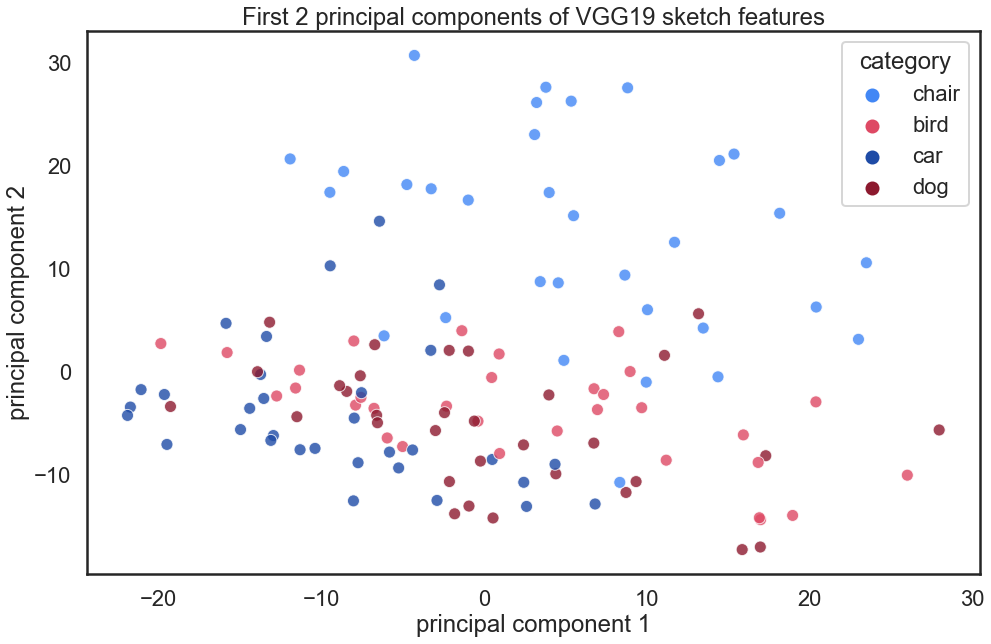

In [638]:
pca_pal = ['#4287f5','#de4964','#1e4ba6','#8c192e']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette(pca_pal),
    data=feats_df1,
    legend="full",
    alpha=0.8
).set_title('First 2 principal components of VGG19 sketch features')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.savefig('nn_PCA.pdf', bbox_inches='tight')

In [229]:
cmap_3d = dict(zip(['chair','bird','car','dog'],pca_pal))

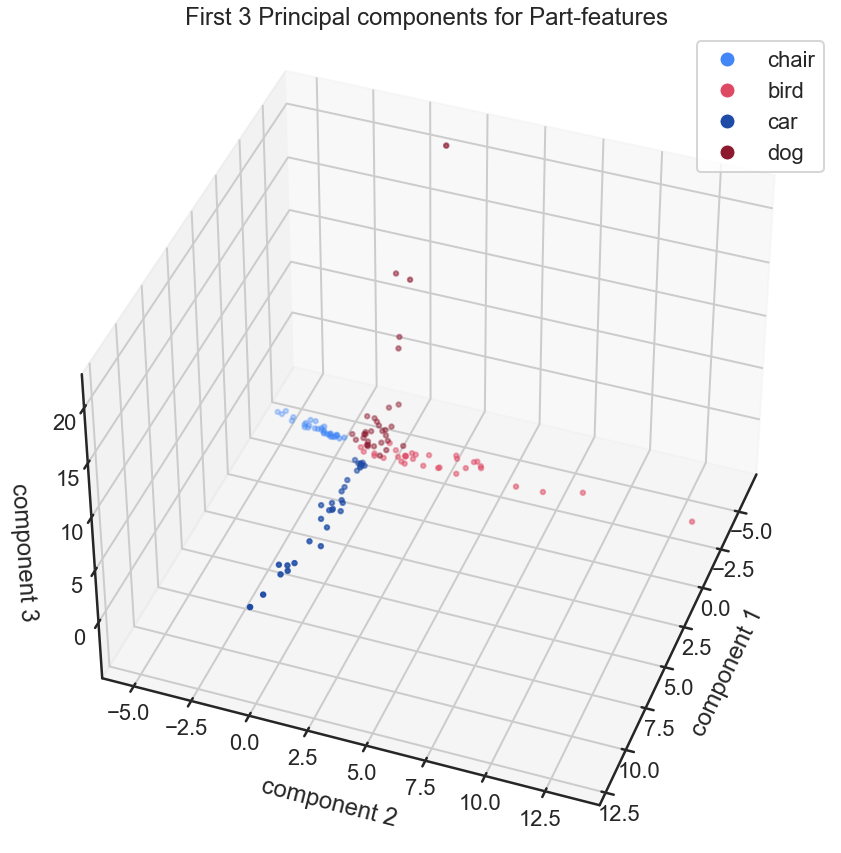

In [637]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.view_init(40, 20)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='chair',
                          markerfacecolor=cmap_3d['chair'], markersize=15),
 Line2D([0], [0], marker='o', color='w', label='bird',
                          markerfacecolor=cmap_3d['bird'], markersize=15),
 Line2D([0], [0], marker='o', color='w', label='car',
                          markerfacecolor=cmap_3d['car'], markersize=15),
 Line2D([0], [0], marker='o', color='w', label='dog',
                          markerfacecolor=cmap_3d['dog'], markersize=15)]


scatter = ax.scatter3D(all_feats['part_pc_1'], all_feats['part_pc_3'], all_feats['part_pc_2'],\
             c=all_feats['category'].apply(lambda x: cmap_3d[x]),);
ax.set_xlabel('component 1',labelpad=20)
ax.set_ylabel('component 2',labelpad=20)
ax.set_zlabel('component 3',labelpad=20)
ax.legend(handles = legend_elements,loc = "upper right")
plt.title("First 3 Principal components for Part-features")
plt.savefig('part_feats.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'part feats visualization')

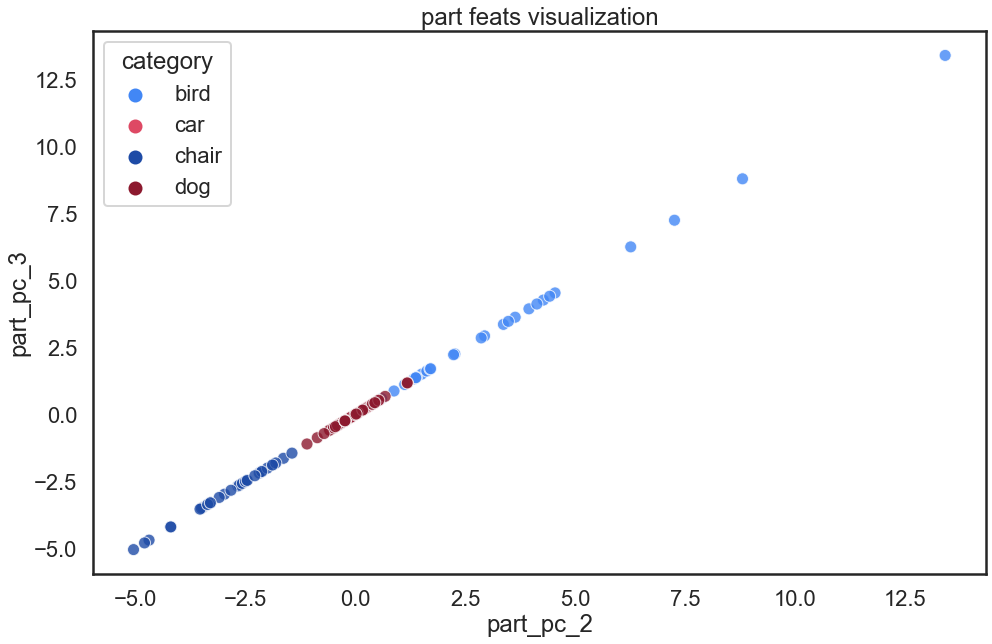

In [645]:
### Out of order

pca_result = pca.fit_transform(all_feats[part_feat_cols].values)

all_feats['part_pc_1'] = pca_result[:,0]
all_feats['part_pc_2'] = pca_result[:,1]
all_feats['part_pc_2'] = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="part_pc_2", y="part_pc_3",
    hue="category",
    palette=sns.color_palette(pca_pal),
    data=all_feats,
    legend="full",
    alpha=0.8
).set_title('part feats visualization')
#

In [18]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_df1[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.001s...
[t-SNE] Computed neighbors for 128 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 14.442571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.416092
[t-SNE] KL divergence after 300 iterations: 0.939779
t-SNE done! Time elapsed: 0.591850996017456 seconds


Text(0.5, 1.0, 't-SNE visualization')

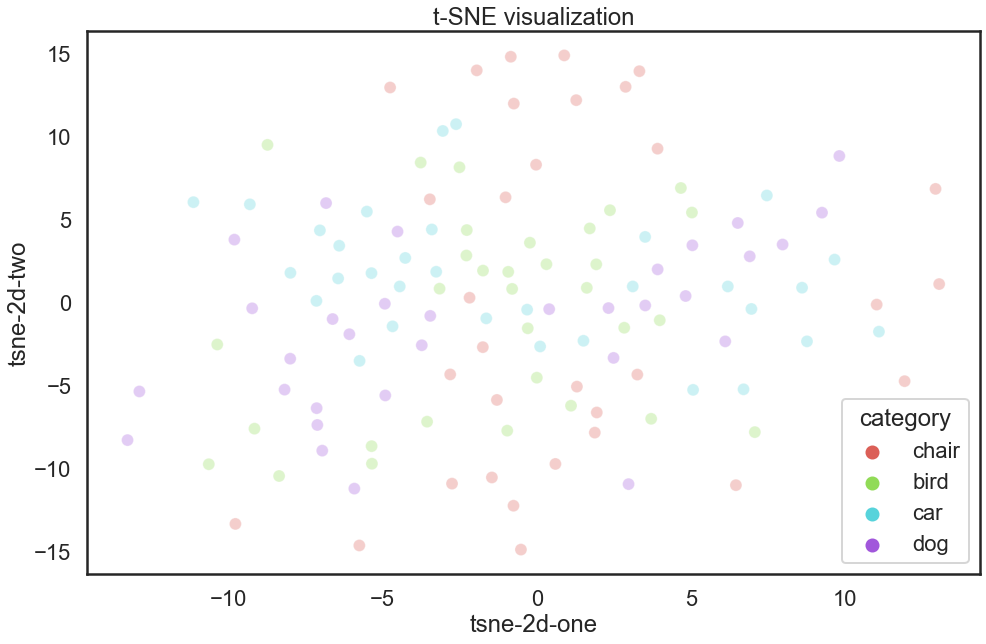

In [19]:
feats_df1['tsne-2d-one'] = tsne_results[:,0]
feats_df1['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df1,
    legend="full",
    alpha=0.3
    
).set_title('t-SNE visualization')

## SALMON data analysis

In [19]:
## Read the many json files that have our triplet judgement data data (clunky for now but best we have)

progress_1 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses220.json'))
progress_2 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses77.json'))
progress_3 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses68.json'))

In [20]:
progress_1.time_received.nunique()

2463

In [21]:
progress_2.time_received.nunique()

358

In [22]:
progress_3.time_received.nunique()

804

In [23]:
progress_1.time_received.nunique()+progress_2.time_received.nunique()+progress_3.time_received.nunique()

3625

In [24]:
##Concatenate all our judgement data

progress_full = pd.concat([progress_1, progress_2,progress_3], axis=0)

In [25]:
progress_full.time_received.nunique()

3625

In [26]:
progress_full.head()
progress_full=progress_full.reset_index()

In [28]:
##Do some string manipulation so that each object is the sketch_id

In [27]:
progress_full.left_object = progress_full.left_object.apply(lambda x: x.split('"')[1])
progress_full.right_object = progress_full.right_object.apply(lambda x: x.split('"')[1])
progress_full.head_object = progress_full.head_object.apply(lambda x: x.split('"')[1])
progress_full.winner_object = progress_full.winner_object.apply(lambda x: x.split('"')[1])

In [30]:
progress_full

,index,head,left,right,winner,puid,time_received,left_object,right_object,head_object,winner_object,left_src,right_src,head_src,winner_src,time_received_since_start
0,0,113,105,103,103,2716393172,1.575402e+09,7285-f99d9991-de84-43cc-b359-e9de387ab0b5_31,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_9,2721-f28245be-a3ac-425e-9538-5c0803980807_3,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_9,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12691.351969
1,1,97,32,29,32,2716393172,1.575402e+09,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_3,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_19,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_18,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_3,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12693.957909
2,2,31,101,7,7,2716393172,1.575402e+09,3956-be947e80-531d-42ce-b238-e0b3bd997edf_8,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_8,1970-1377644d-0742-4343-ae91-737a5b0fbd1f_8,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_8,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12697.453488
3,3,34,67,22,67,2716393172,1.575402e+09,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_32,2611-14794729-06be-4093-aac5-8a631b1fa894_26,6486-e7055f99-5fec-4fb7-a7fd-7ebf49ba594f_31,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_32,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12699.013656
4,4,119,16,60,60,2716393172,1.575402e+09,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_20,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_17,6311-cd21a68a-f1df-4290-b744-b0c7c7c60ed8_21,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_17,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12702.653413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,799,127,35,99,35,1955754682,1.575477e+09,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_15,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_21,2721-f28245be-a3ac-425e-9538-5c0803980807_5,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_15,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2964.418308
3621,800,123,50,63,63,1955754682,1.575477e+09,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_8,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_13,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_5,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_13,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2966.183925
3622,801,6,92,42,42,1955754682,1.575477e+09,8265-92081336-152b-4a90-bdb4-fea038f4c9b8_18,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_14,5708-fd15d921-aa1b-46e4-ad51-e0c743c2db0d_25,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_14,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2967.896623
3623,802,98,94,115,115,1955754682,1.575477e+09,6224-40ab6004-b7c1-4d1d-a308-a061099290fc_1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_13,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubuserco

In [28]:
feats_df1 ## This is our CNN Data

,feature_ind,sketch_id,0,1,2,3,4,5,6,7,...,4092,4093,4094,4095,condition,category,target,pca-one,pca-two,pca-three
0,0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,2.076044,0.886450,0.000000,0.0,0.0,0.000000,0.836140,0.0,...,0.000000,0.0,0.000000,1.927369,further,chair,squat,9.961466,-1.029404,-8.188345
1,1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,2.452158,2.412398,0.508882,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,2.391883,further,bird,bluejay,16.918644,-14.407351,1.030227
2,2,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_18,2.603316,2.160689,0.000000,0.0,0.0,0.000000,0.959337,0.0,...,0.000000,0.0,0.000000,0.983835,further,chair,knob,20.475914,6.199675,2.294074
3,3,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_29,1.819171,1.241084,0.000000,0.0,0.0,0.229416,0.930181,0.0,...,0.000000,0.0,0.000000,1.246116,closer,bird,tomtit,15.935179,-6.191392,-15.327803
4,4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,0.851439,0.915498,0.000000,0.0,0.0,0.891402,0.038671,0.0,...,0.000000,0.0,0.000000,0.779328,closer,bird,nightingale,-7.884558,-3.195322,-9.901801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_9,3.061178,0.737765,0.000000,0.0,0.0,0.000000,0.315829,0.0,...,0.000000,0.0,0.000000,2.034183,further,chair,woven,14.372038,-0.531934,-3.961840
124,124,8486-a0a44a5f-4eb9-4924-b2b6-247478e1ce8d_6,2.074374,0.000000,1.193633,0.0,0.0,0.000000,0.000000,0.0,...,0.441937,0.0,0.000000,0.000000,further,chair,straight,-11.785801,20.712490,-0.116782
125,125,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_14,1.402668,0.830638,0.000000,0.0,0.0,0.181231,1.101940,0.0,...,0.000000,0.0,0.000000,1.225736,further,dog,pug,0.506942,-14.190082,0.274398
126,126,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_21,1.140599,0.134968,0.000000,0.0,0.0,0.267462,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,closer,car,brown,-6.314549,14.637459,-8.432273


In [29]:
### Save out to csvs to avoid having to do all this again

#feats_df1.to_csv(os.path.join(data_dir, 'CNN_feats_plus_meta.csv'))
#progress_full.to_csv(os.path.join(data_dir, 'triplet_judgements.csv'))
feats_df1=pd.read_csv(os.path.join(data_dir, 'CNN_feats_plus_meta.csv'))

## How well can we predict judgements using CNN features?

In [30]:
feat_cols = np.arange(0,4096).astype(str).tolist()
#mdist = np.corrcoef(feats_df1[feat_cols]) ### distance matrix of cnn feats using correlation


In [31]:
import scipy
mdist = scipy.spatial.distance.pdist(feats_df1[feat_cols], metric='euclidean')### distance matrix of cnn feats using euclidean dist
mdist = scipy.spatial.distance.squareform(mdist)

In [685]:
def score(fdf, ndf, feat_cols, distmat=None):
    #print(distmat)
    if distmat is not None:
        mdist = distmat  
    else:
        mdist = scipy.spatial.distance.pdist(fdf[feat_cols], metric='euclidean')
        mdist = scipy.spatial.distance.squareform(mdist)
        
    o = np.zeros(ndf.shape[0])
    dist_df = pd.DataFrame(mdist, columns=fdf.sketch_id, index=fdf.sketch_id)
    
    mitems = dist_df.index
    nitems =ndf.shape[0]
    for i in range(nitems):
        ivec =  dist_df[dist_df.index==ndf['head_object'].iloc[i]]
        dleft = ivec[ndf['left_object'].iloc[i]].values
        dright = ivec[ndf['right_object'].iloc[i]].values
        if(dleft<dright):
            pred = ndf.left_object.iloc[i]
        elif (dleft<dright):
            pred = ndf.right_object.iloc[i]
        else:
            pred = [ndf.right_object.iloc[i], ndf.right_object.iloc[i]][int(np.random.binomial(1,.5,1))]
        if(pred==ndf.winner_object.iloc[i]):
            o[i] = 1
    return(o)

NameError: name 'ndf' is not defined

In [553]:
D.label.unique()

array(['leg', 'seat', 'backrest', 'armrest', 'wheel', 'trunk', 'body',
       'door', 'window', 'hood', 'headlight', 'windshield', 'mouth',
       'head', 'eye', 'tail', 'bumper', 'unknown', 'ear', 'neck', 'feet',
       'beak', 'wing', 'paw'], dtype=object)

In [33]:
np.mean(results) ## mean accuracy using cnn feats ~60% not bad :) 
np.mean(results_parts)
np.mean(results_cats)
np.mean(results_sm)

NameError: name 'results' is not defined

In [34]:
embed_labels = pd.read_csv(os.path.join(data_dir,'labels.txt'),header=None) ### read in next features

In [35]:
embed_coords = pd.read_csv(os.path.join(data_dir,'model.csv'), header=None)
embed_df= pd.concat([embed_labels,embed_coords],axis=1)
embed_df.columns = ['sketch_id','coord_1','coord_2']

embed_df['category']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].category)

embed_df['condition']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].condition)

embed_df['target']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].target)





,sketch_id,coord_1,coord_2,category,condition,target
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,-0.752380,-0.264624,chair,further,squat
1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,0.185680,-0.739970,bird,further,bluejay
2,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_18,-0.814600,0.016308,chair,further,knob
3,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_29,0.552759,-0.777588,bird,closer,tomtit
4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,0.181378,-0.813359,bird,closer,nightingale
...,...,...,...,...,...,...
123,8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_9,-0.788353,-0.151863,chair,further,woven
124,8486-a0a44a5f-4eb9-4924-b2b6-247478e1ce8d_6,-1.018409,-0.434231,chair,further,straight
125,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_14,0.738470,0.040265,dog,further,pug
126,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_21,0.013112,1.491223,car,closer,brown


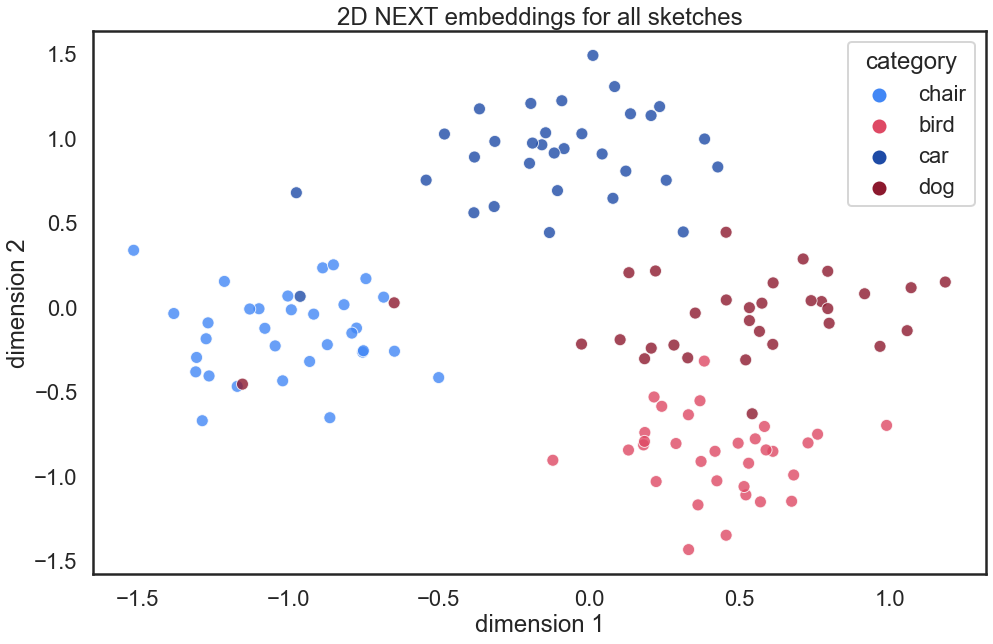

In [636]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="coord_1", y="coord_2",
    hue="category",
    palette=sns.color_palette(pca_pal),
    data=embed_df,
    legend="full",
    alpha=0.8
).set_title('2D NEXT embeddings for all sketches')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')



plt.savefig('next_PCA.pdf',bbox_inches='tight')


## SPRING 2020 Analyses

In [38]:
cnn_feats = pd.read_csv(os.path.join(data_dir,'CNN_feats_plus_meta.csv')) ## read in cnn feats of 128 sketches

In [39]:
feat_cols = np.arange(0,4096).astype(str).tolist()


In [40]:
next_df = pd.read_csv(os.path.join(data_dir,'triplet_judgements.csv'))  ## read in next judgement data

In [41]:

D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))
D.sketch_svg_string = D.sketch_svg_string.apply(listify)

In [42]:
### Create a dataframe of strokes and compute the length of those strokes. Each row is a unique stroke from the
### set of 128 sketches we used for NEXT

from svgpathtools import parse_path

unique_cats = D.category.unique()


from collections import Counter
from collections import OrderedDict

stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})

##Adding total arclength information to stroke dataframe

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print ('zero div error')
        arclength = 0
    return arclength
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

In [67]:
### Create part-based semantic vectors using this stroke dataframe

In [43]:
unique_cats= np.unique(D['category'])
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}


##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
    
#     sns.set_context('talk')
#     plt.figure(figsize=(12,7))
#     plt.ylim(0,1)
#     h = plt.bar(plot_labels,prop_labels)
#     plt.title('Proportion of {} annotations with labels'.format(category))
#     plt.ylabel('proportion of annotations')
#     plt.xlabel('Part')
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]

In [44]:
###This is where we make a num unique labels * 2 X number of sketches vector 

feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    print (start_pos, end_pos)
    clear_output(wait=True)
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'].unique(),DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
meta_df = pd.DataFrame(meta_list, columns=cols)

    


24 34


In [45]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
meta_df['sketch_id']=meta_df['sketch_id'].apply(arr_to_str)
meta_df['target']=meta_df['target'].apply(arr_to_str)
meta_df['condition']=meta_df['condition'].apply(arr_to_str)
meta_df['category']=meta_df['category'].apply(arr_to_str)
meta_df['outcome']=meta_df['outcome'].apply(arr_to_str)
    



In [46]:
feature_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])


##Creating a compressed version of the feature df with no duplicates for parts. E.g. - no difference between
## dog leg and chair leg

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
feature_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in feature_df if col.startswith(this_lab)]
    feature_df_final[this_lab]= feature_df[duplicates].sum(axis=1)
feature_df = feature_df_final

In [47]:
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X
feature_df = normalize(feature_df)

In [48]:
part_feats = pd.concat((meta_df,feature_df),axis=1) ## dataframe for semantic features

In [49]:
part_feat_cols= feature_df.columns

In [50]:
part_feats_sub = part_feats[part_feats.sketch_id.isin(cnn_feats.sketch_id)]

In [51]:
cnn_feat_cols = np.arange(0,4096).astype(str).tolist()

In [52]:
## Read in NEXT embeddings and add necessary metadata for subsetting purposes

next_feats = pd.read_csv(os.path.join(data_dir,'model.csv'), header=None)
next_feats= pd.concat([embed_labels,embed_coords],axis=1)
next_feats.columns = ['sketch_id','coord_1','coord_2']
next_feat_cols = ['coord_1','coord_2']

next_feats['category']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].category)

next_feats['condition']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].condition)

next_feats['target']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].target)





In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [79]:
### Concantenate all feats into a single df for now. Very hacky, find a better way to do this soon.

In [54]:
all_feats = pd.merge(pd.merge(next_feats,cnn_feats,on='sketch_id'),part_feats_sub.reset_index(),on='sketch_id')

In [81]:
train,test = train_test_split( all_feats, test_size=0.3,\
                                                    stratify= all_feats[['target_x','category_x']])


In [82]:
next_dist_t = scipy.spatial.distance.pdist(train[next_feat_cols], metric='euclidean')
next_dist_t = scipy.spatial.distance.squareform(next_dist_t)

cnn_dist_t = scipy.spatial.distance.pdist(train[cnn_feat_cols], metric='euclidean')
cnn_dist_t = scipy.spatial.distance.squareform(cnn_dist_t)

part_dist_t = scipy.spatial.distance.pdist(train[part_feat_cols], metric='euclidean')
part_dist_t =  scipy.spatial.distance.squareform(part_dist_t)

In [83]:
###get indices for lower triangle
tri_inds = np.tril_indices(next_dist_t.shape[0],-1) ### The first argument is the shape of the square matrix 
###the second argument shifts the diagonal left by 1 row so as to not include tha diagonal

next_dist_t = next_dist_t[tri_inds]
cnn_dist_t = cnn_dist_t[tri_inds]
part_dist_t = part_dist_t[tri_inds]

In [84]:
next_dist_v = scipy.spatial.distance.pdist(test[next_feat_cols], metric='euclidean')
next_dist_v = scipy.spatial.distance.squareform(next_dist_v)

cnn_dist_v = scipy.spatial.distance.pdist(test[cnn_feat_cols], metric='euclidean')
cnn_dist_v = scipy.spatial.distance.squareform(cnn_dist_v)

part_dist_v = scipy.spatial.distance.pdist(test[part_feat_cols], metric='euclidean')
part_dist_v =  scipy.spatial.distance.squareform(part_dist_v)

In [85]:
tri_inds = np.tril_indices(next_dist_v.shape[0],-1) ###

next_dist_v = next_dist_v[tri_inds]
cnn_dist_v = cnn_dist_v[tri_inds]
part_dist_v = part_dist_v[tri_inds]

In [55]:
all_feats

,sketch_id,coord_1,coord_2,category_x,condition_x,target_x,Unnamed: 0,feature_ind,0,1,...,neck_total_arclength,paw_total_arclength,seat_total_arclength,tail_total_arclength,trunk_total_arclength,unknown_total_arclength,wheel_total_arclength,window_total_arclength,windshield_total_arclength,wing_total_arclength
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,-0.752380,-0.264624,chair,further,squat,0,0,2.076044,0.886450,...,-0.084783,-0.078155,1.513923,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,0.185680,-0.739970,bird,further,bluejay,1,1,2.452158,2.412398,...,-0.084783,-0.078155,-0.512509,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
2,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_18,-0.814600,0.016308,chair,further,knob,2,2,2.603316,2.160689,...,-0.084783,-0.078155,1.745685,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
3,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_29,0.552759,-0.777588,bird,closer,tomtit,3,3,1.819171,1.241084,...,-0.084783,-0.078155,-0.512509,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,6.505107
4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,0.181378,-0.813359,bird,closer,nightingale,4,4,0.851439,0.915498,...,-0.084783,-0.078155,-0.512509,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,1.526323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_9,-0.788353,-0.151863,chair,further,woven,123,123,3.061178,0.737765,...,-0.084783,-0.078155,1.151423,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
124,8486-a0a44a5f-4eb9-4924-b2b6-247478e1ce8d_6,-1.018409,-0.434231,chair,further,straight,124,124,2.074374,0.000000,...,-0.084783,-0.078155,1.014743,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
125,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_14,0.738470,0.040265,dog,further,pug,125,125,1.402668,0.830638,...,-0.084783,-0.078155,-0.512509,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343
126,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_21,0.013112,1.491223,car,closer,brown,126,126,1.140599,0.134968,...,-0.084783,-0.078155,-0.512509,-0.358546,-0.126676,-0.199531,0.968694,1.268236,2.849925,-0.246343


In [56]:
X = tuple(zip(cnn_dist_t, part_dist_t))
y = next_dist_t

NameError: name 'cnn_dist_t' is not defined

In [ ]:
model = LinearRegression().fit(X, y)

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
X_v = tuple(zip(cnn_dist_v, part_dist_v))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [ ]:
pred = model.predict(X_v)

In [ ]:
mean_squared_error(next_dist_v, pred)

In [ ]:
r2_score(next_dist_v, pred)

In [ ]:
explained_variance_score(next_dist_v, pred)

In [ ]:
naive_y = np.full(len(next_dist_v), np.mean(y))

In [ ]:
mean_squared_error(next_dist_v, naive_y)

In [ ]:
r2_score(next_dist_v, naive_y)

In [ ]:
explained_variance_score(next_dist_v, naive_y)

In [554]:
class ShapeContext(object):

    def __init__(self, nbins_r=5, nbins_theta=12, r_inner=0.1250, r_outer=2.0):
        # number of radius zones
        self.nbins_r = nbins_r
        # number of angles zones
        self.nbins_theta = nbins_theta
        # maximum and minimum radius
        self.r_inner = r_inner
        self.r_outer = r_outer

    def _hungarian(self, cost_matrix):
        """
            Here we are solving task of getting similar points from two paths
            based on their cost matrixes. 
            This algorithm has dificulty O(n^3)
            return total modification cost, indexes of matched points
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total = cost_matrix[row_ind, col_ind].sum()
        indexes = zip(row_ind.tolist(), col_ind.tolist())
        return total, indexes

    def get_points_from_img(self, image, threshold=50, simpleto=300, radius=2):
        """
            That is not very good algorithm of choosing path points, but it will work for our case.

            Idea of it is just to create grid and choose points that on this grid.
        """
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dst = cv2.Canny(image, threshold, threshold * 3, 3)

        py, px = np.gradient(image)
        # px, py gradients maps shape can be smaller then input image shape
        points = [index for index, val in np.ndenumerate(dst)
                  if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
        h, w = image.shape

        _radius = radius
        while len(points) > simpleto:
            newpoints = points
            xr = range(0, w, _radius)
            yr = range(0, h, _radius)
            for p in points:
                if p[0] not in yr and p[1] not in xr:
                    newpoints.remove(p)
                    if len(points) <= simpleto:
                        T = np.zeros((simpleto, 1))
                        for i, (y, x) in enumerate(points):
                            radians = math.atan2(py[y, x], px[y, x])
                            T[i] = radians + 2 * math.pi * (radians < 0)
                        return points, np.asmatrix(T)
            _radius += 1

        T = np.zeros((simpleto, 1))
        
        for i, (y, x) in enumerate(points):
            
            radians = math.atan2(py[y, x], px[y, x])
            
            T[i] = radians + 2 * math.pi * (radians < 0)

        return points, np.asmatrix(T)

    def _cost(self, hi, hj):
        cost = 0
        for k in range(self.nbins_theta * self.nbins_r):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k])**2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost_by_paper(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in range(p):
            for j in range(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

    def compute(self, points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points)
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [am // t_points, am % t_points]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(self.nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        norm_angle = theta_array[max_points[0], max_points[1]]
        # making angles matrix rotation invariant
        theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0

        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta))).astype(int)

        # building point descriptor based on angle and distance
        nbins = self.nbins_theta * self.nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in range(t_points):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in range(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)

        return descriptor

    def cosine_diff(self, P, Q):
        """
            Fast cosine diff.
        """
        P = P.flatten()
        Q = Q.flatten()
        assert len(P) == len(Q), 'number of descriptors should be the same'
        return cosine(P, Q)

    def diff(self, P, Q, qlength=None):
        """
            More precise but not very speed efficient diff.

            if Q is generalized shape context then it compute shape match.

            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.

        """
        result = None
        C = self.cost_by_paper(P, Q, qlength)

        result = self._hungarian(C)

        return result

    @classmethod
    def tests(cls):
        # basics tests to see that all algorithm invariants options are working fine
        self = cls()

        def test_move():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # +30 by x
            p2 = np.array([
                [0, 130],
                [200, 90],
                [350, 250],
                [370, 130],
                [70, 330]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Moving points in 2d space should give same shape context vector"

        def test_scale():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # 2x scaling
            p2 = np.array([
                [0, 200],
                [400, 120],
                [700, 440],
                [740, 200],
                [149, 600]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Scaling points in 2d space should give same shape context vector"

        def test_rotation():
            p1 = np.array(
                [(144, 196), (220, 216), (330, 208)]
            )
            # 90 degree rotation
            theta = np.radians(90)
            c, s = np.cos(theta), np.sin(theta)
            R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            p2 = np.dot(p1, R).tolist()

            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Rotating points in 2d space should give same shape context vector"

        test_move()
        test_scale()
        test_rotation()
        print ('Tests PASSED')


ShapeContext.tests()


def get_diff(img,img2, rotate=False):
    sc = ShapeContext()
    sampls = 200

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
#    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q, qlength=sampls)
    return standard_cost
    #print ("Diff:", standard_cost)

    
    
def sc_plot(img, img2, rotate=False):
    sc = ShapeContext()
    sampls = 200

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
#    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q, qlength=sampls)
    
    lines = []
    for p,q in indexes:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))
        
    fig = plt.figure(figsize=(20,10))
    #ax = plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.gca().invert_yaxis()
    #plt.plot(x1,y1,'go', x2,y2, 'ro')
    plt.plot(x1,y1,'go')
    
    #ax = plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go',x2,y2,'ro')
    for p1,p2 in lines:   
        plt.gca().invert_yaxis()
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
    #plt.show()
    print ("Cosine diff:", cosine(P.flatten(), Q.flatten()))
    print ("Standard diff:", standard_cost)

  


Tests PASSED


In [58]:



### Create a function to subset our dataframes by conditions as we need 

def subset_dataframe_by_condition(F,to_inspect='all',this_category='bird',this_object='bluejay'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_listf = F[(far_inds) & obj_inds]['target'].values
        obj_listc = F[(close_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_listf = F[(category_inds) & (far_inds)]['target'].values
        obj_listc = F[(category_inds) & (close_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_listf = F[far_inds]['target'].values
        obj_listc = F[close_inds]['target'].values
        
    return c, f, obj_listc, obj_listf

In [59]:
 c1, f1, obj_listc1, obj_listf1 = subset_dataframe_by_condition(part_feats,to_inspect='all')

In [277]:
#### Generate ordered list of objects

cats = ['bird','car','chair','dog']
obj_list = []
cat_to_obj = {}
for this_cat in cats:
    fs = next_feats[next_feats.category == this_cat]
    obj_list.append(list(np.unique(fs.target.values)))
    cat_to_obj[this_cat] = list(np.unique(fs.target.values))
    

In [278]:
obj_list = [y for x in obj_list for y in x]

In [279]:
next_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        next_ob_means.append(np.array(next_feats[next_feats.target==this_ob][next_feat_cols].mean()))
        
next_ob_means = np.stack(next_ob_means)

In [280]:
cnn_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        cnn_ob_means.append(np.array(cnn_feats[cnn_feats.target==this_ob][cnn_feat_cols].mean()))
        
cnn_ob_means = np.stack(cnn_ob_means)

In [281]:
part_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        part_ob_means.append(np.array(part_feats_sub[part_feats_sub.target==this_ob][part_feat_cols].mean()))
        
part_ob_means = np.stack(part_ob_means)

In [282]:
ob_means_all = np.concatenate((next_ob_means, cnn_ob_means,part_ob_means), axis=1)

In [283]:
ob_cols = [y for x in [next_feat_cols,cnn_feat_cols, part_feat_cols] for y in x]
all_ob_means = pd.DataFrame(ob_means_all,
                     columns = ob_cols)

In [284]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [285]:
all_ob_means['target'] = pd.Series(obj_list)
all_ob_means['category']= all_ob_means['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])


In [286]:
obj_list

['bluejay',
 'crow',
 'cuckoo',
 'nightingale',
 'pigeon',
 'robin',
 'sparrow',
 'tomtit',
 'beetle',
 'bluesedan',
 'bluesport',
 'brown',
 'hatchback',
 'redantique',
 'redsport',
 'white',
 'inlay',
 'knob',
 'leather',
 'sling',
 'squat',
 'straight',
 'waiting',
 'woven',
 'basset',
 'bloodhound',
 'bullmastiff',
 'chihuahua',
 'doberman',
 'goldenretriever',
 'pug',
 'weimaraner']

In [111]:
train_means,test_means = train_test_split( all_ob_means, test_size=0.3,\
                                                    stratify= all_ob_means['category'])


## Train test versions of regs

In [112]:
next_dist_t = scipy.spatial.distance.pdist(train_means[next_feat_cols], metric='euclidean')
next_dist_t = scipy.spatial.distance.squareform(next_dist_t)

cnn_dist_t = scipy.spatial.distance.pdist(train_means[cnn_feat_cols], metric='euclidean')
cnn_dist_t = scipy.spatial.distance.squareform(cnn_dist_t)

part_dist_t = scipy.spatial.distance.pdist(train_means[part_feat_cols], metric='euclidean')
part_dist_t =  scipy.spatial.distance.squareform(part_dist_t)

In [113]:
tri_inds = np.tril_indices(next_dist_t.shape[0],-1)

next_dist_t = next_dist_t[tri_inds]
cnn_dist_t = cnn_dist_t[tri_inds]
part_dist_t = part_dist_t[tri_inds]

In [114]:
next_dist_v = scipy.spatial.distance.pdist(test_means[next_feat_cols], metric='euclidean')
next_dist_v = scipy.spatial.distance.squareform(next_dist_v)

cnn_dist_v = scipy.spatial.distance.pdist(test_means[cnn_feat_cols], metric='euclidean')
cnn_dist_v = scipy.spatial.distance.squareform(cnn_dist_v)

part_dist_v = scipy.spatial.distance.pdist(test_means[part_feat_cols], metric='euclidean')
part_dist_v =  scipy.spatial.distance.squareform(part_dist_v)

In [115]:
tri_inds = np.tril_indices(next_dist_v.shape[0],-1)

next_dist_v = next_dist_v[tri_inds]
cnn_dist_v = cnn_dist_v[tri_inds]
part_dist_v = part_dist_v[tri_inds]

## Fit full data


In [274]:
all_feats.target_x

0         bluejay
1         bluejay
2         bluejay
3         bluejay
4            crow
          ...    
123           pug
124    weimaraner
125    weimaraner
126    weimaraner
127    weimaraner
Name: target_x, Length: 128, dtype: object

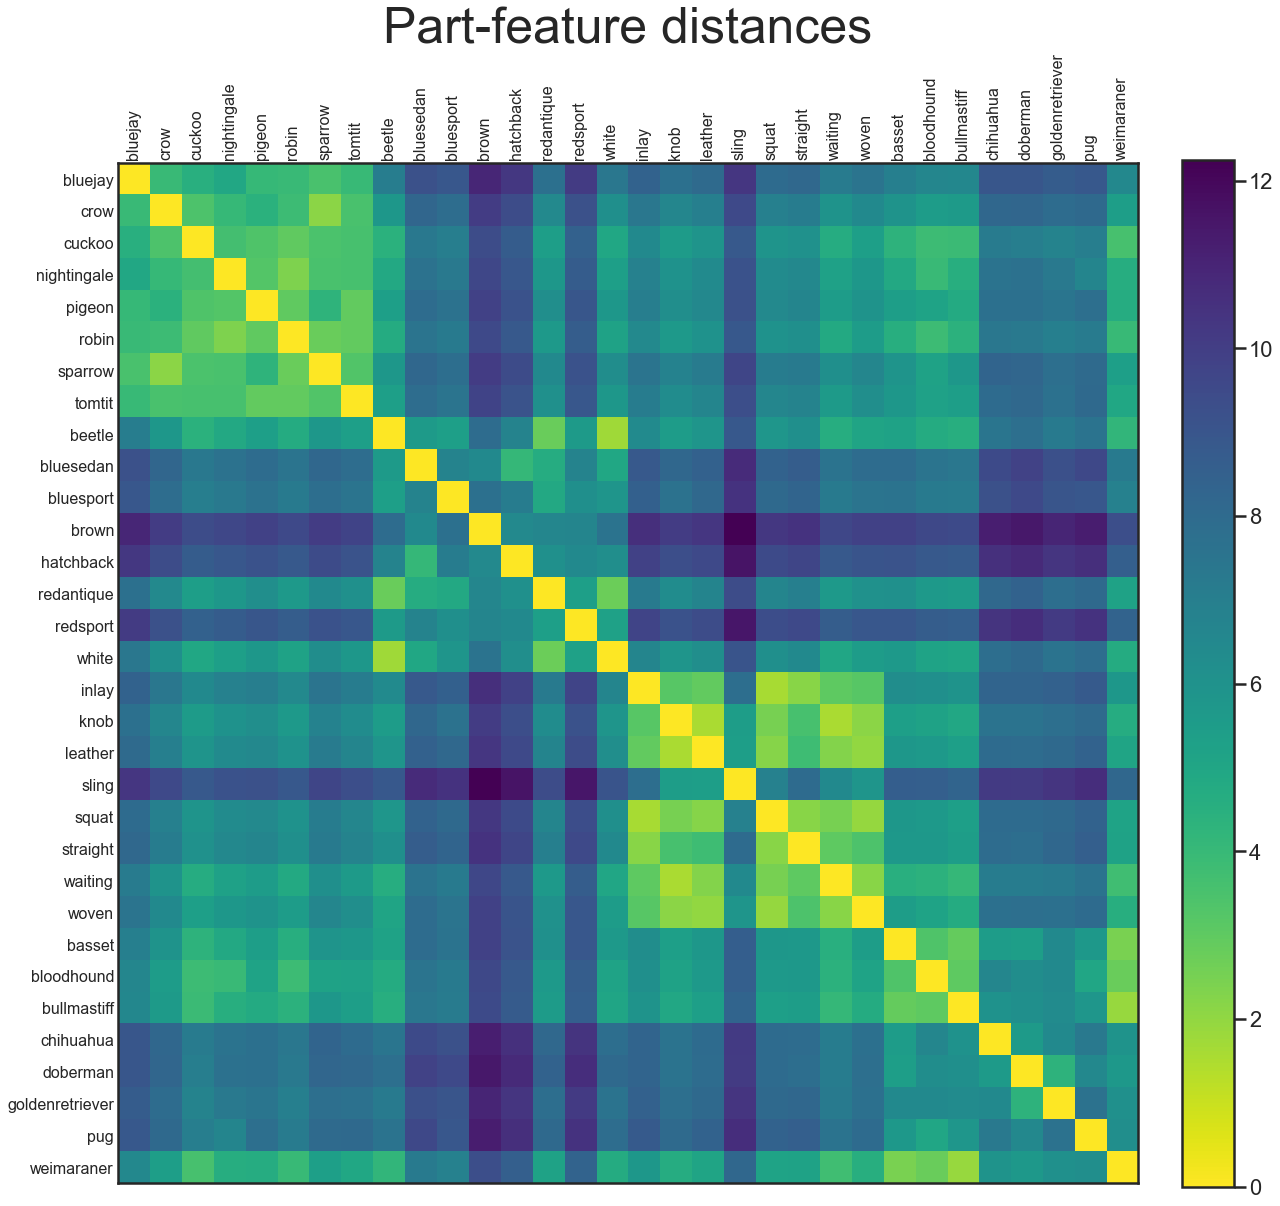

In [627]:
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(all_ob_means[part_feat_cols], metric='euclidean'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Part-feature distances', fontsize=50)
plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()

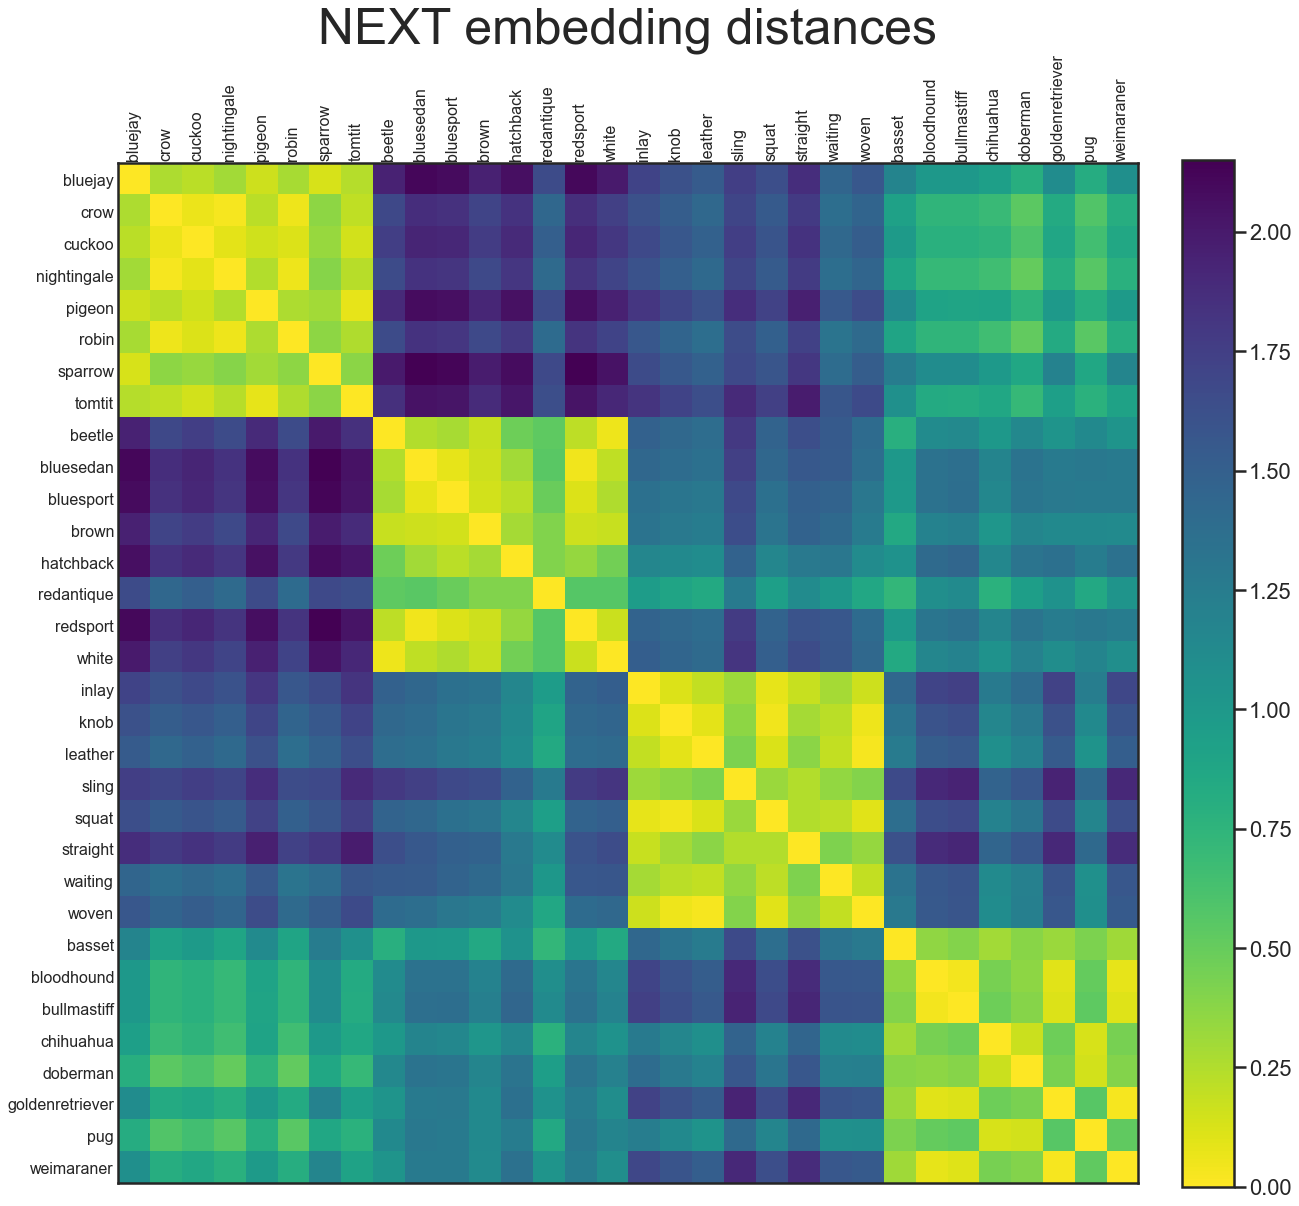

In [628]:
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(all_ob_means[next_feat_cols], metric='euclidean'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('NEXT embedding distances', fontsize=50)
plt.savefig('NEXT_dist.pdf',bbox_inches='tight')
plt.show()

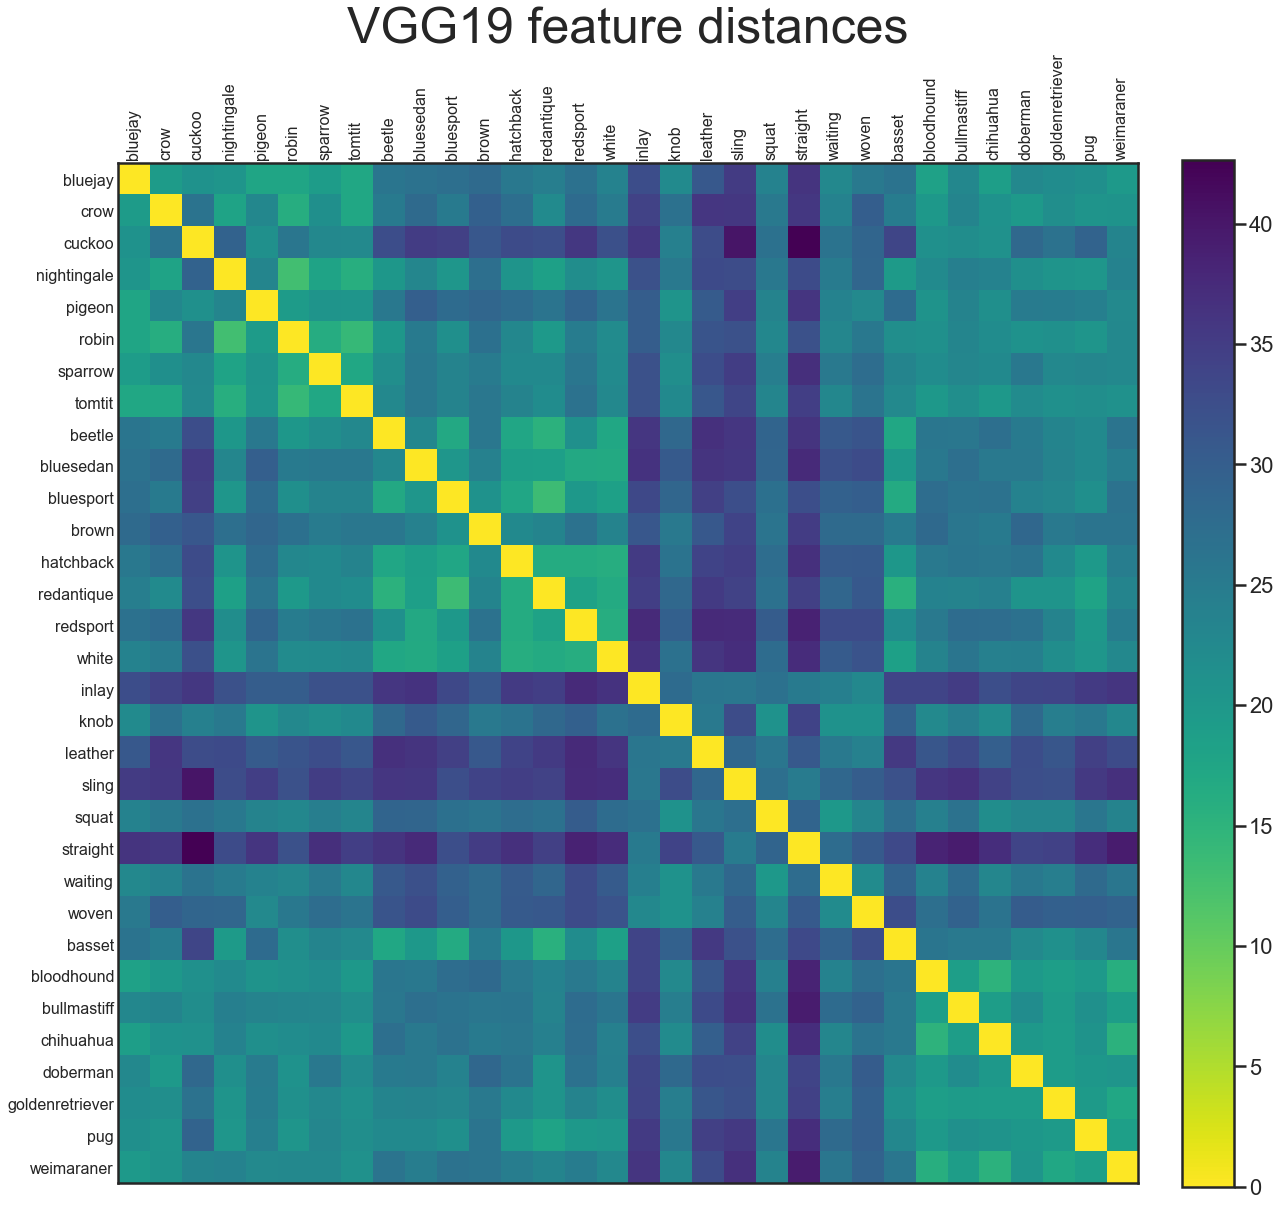

In [629]:
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(all_ob_means[cnn_feat_cols], metric='euclidean'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('VGG19 feature distances', fontsize=50)
plt.savefig('vgg_dist.pdf',bbox_inches='tight')
plt.show()

In [559]:
cat_dist_f_mean = np.ones((32,32))
for i in range(all_ob_means.shape[0]):
    for j in range(all_ob_means.shape[0]):
        if all_ob_means.category[i] == all_ob_means.category[j]:
            cat_dist_f_mean[i,j]=0


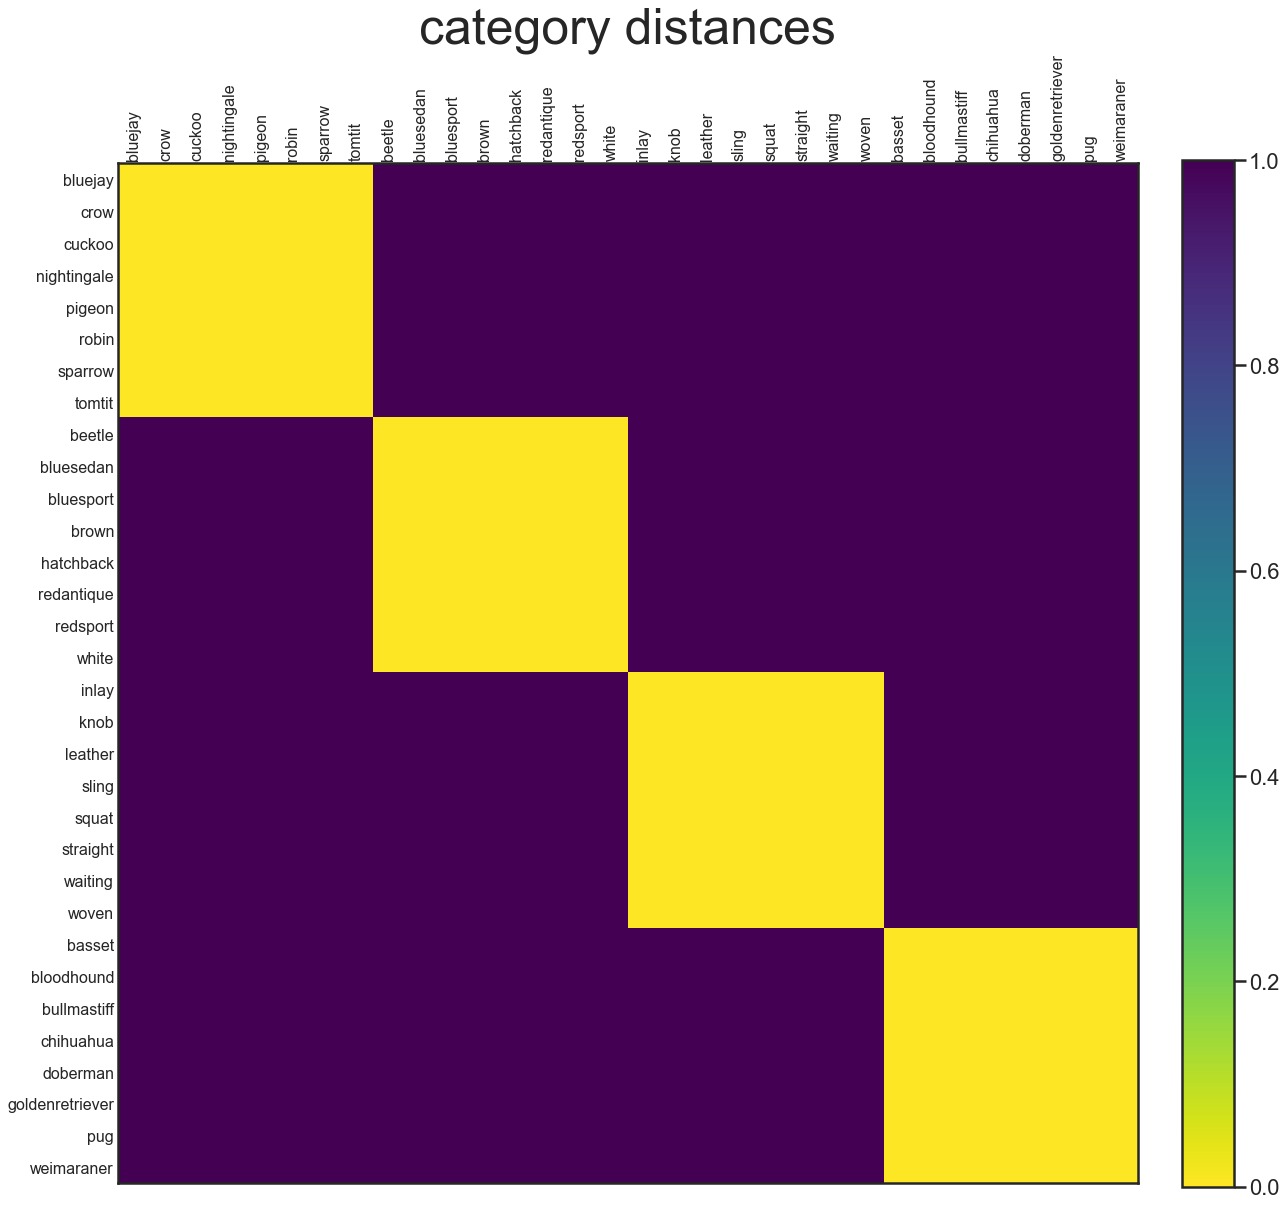

In [630]:
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(all_ob_means[cnn_feat_cols], metric='euclidean'))

plt.figure(figsize=(20,20))
plt.matshow(cat_dist_f_mean,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('category distances', fontsize=50)
plt.savefig('cat_dist.pdf',bbox_inches='tight')
plt.show()

In [75]:
sm_dist_f = np.load('../sm_dists.npy')

AttributeError: 'Text' object has no property 'bbox_inches'

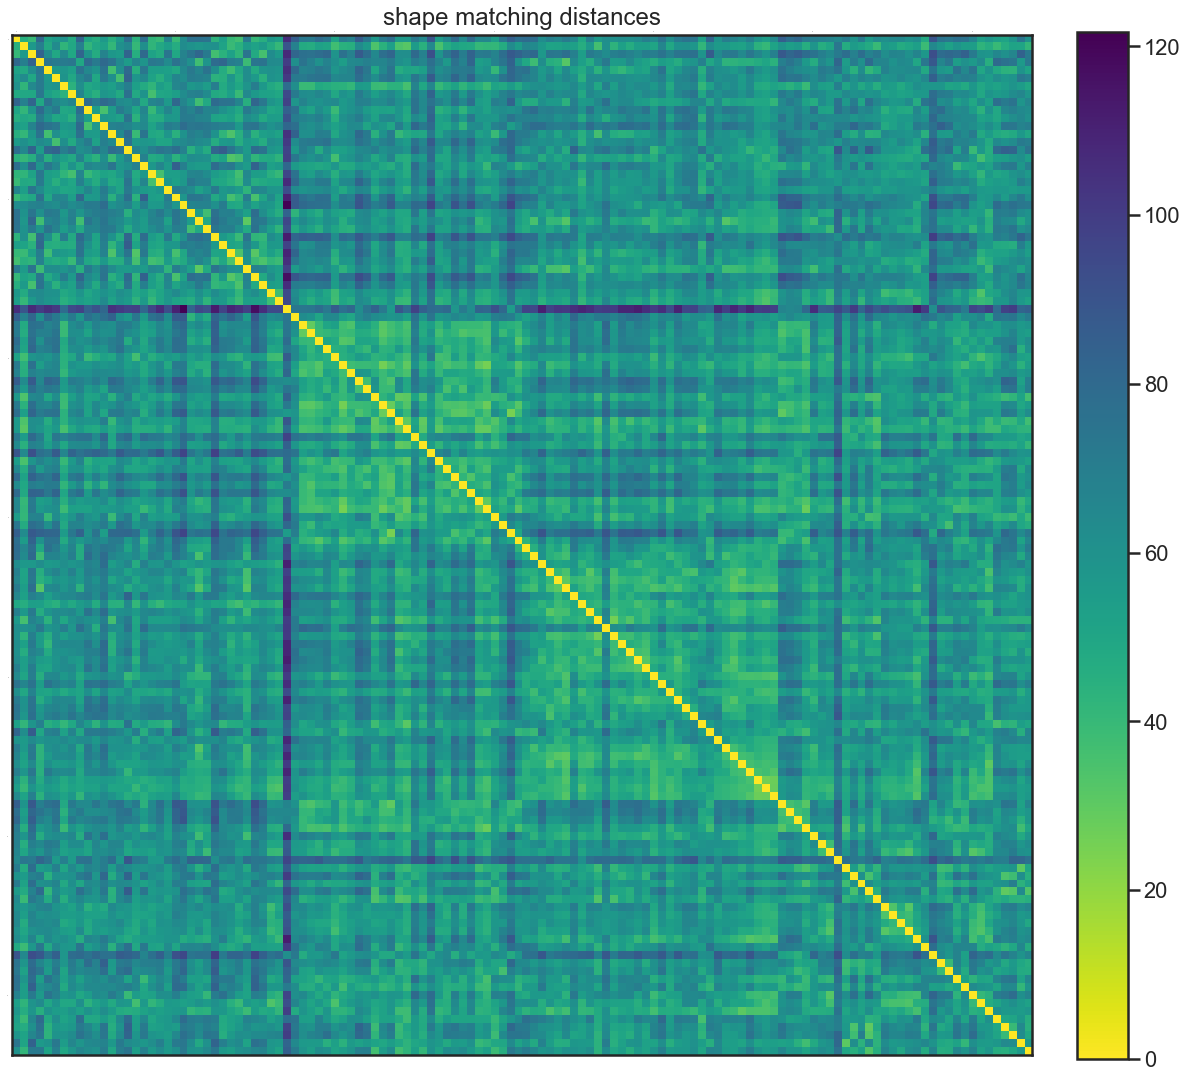

In [631]:
###NOTE
plt.figure(figsize=(20,20))
plt.matshow(sm_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
# plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('shape matching distances',)

plt.show()

In [117]:
sm_dist_f_mean = np.ones((32,32))

start_indr = 0
for i in np.arange(0, sm_dist_f.shape[0],4):
    end_indr = i+4
    start_indc = 0
    
    for j in np.arange(0, sm_dist_f.shape[0],4):
        end_indc=j+4
        sm_dist_f_mean[int(i/4),int(j/4)]=np.mean(sm_dist_f[start_indr:end_indr, start_indc:end_indc])
        start_indc = j+4
    start_indr = i+4
        
    
    
   

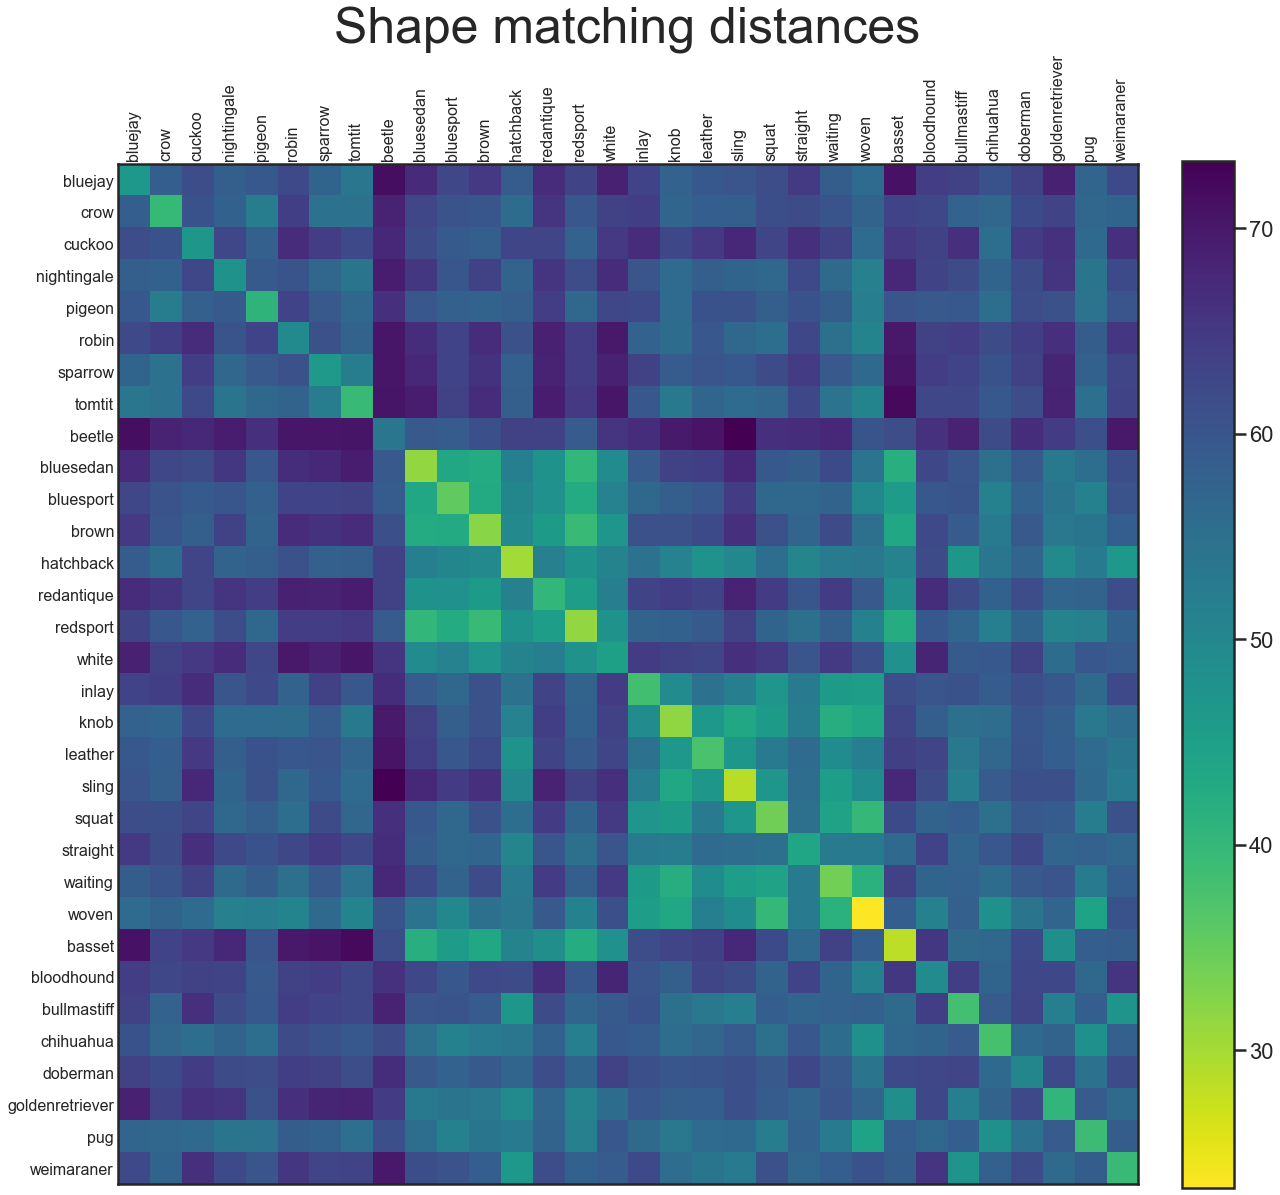

In [632]:
###NOTE
plt.figure(figsize=(20,20))
plt.matshow(sm_dist_f_mean,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Shape matching distances', fontsize=50)
plt.savefig('shape_dist.pdf',bbox_inches='tight')
plt.show()

In [111]:
sm_dist_f_mean[:,0]

array([46.6994152,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])

In [293]:
next_dist_f_mean = scipy.spatial.distance.pdist(all_ob_means[next_feat_cols], metric='euclidean')
next_dist_f_mean = scipy.spatial.distance.squareform(next_dist_f_mean)

cnn_dist_f_mean = scipy.spatial.distance.pdist(all_ob_means[cnn_feat_cols], metric='euclidean')
cnn_dist_f_mean = scipy.spatial.distance.squareform(cnn_dist_f_mean)

part_dist_f_mean = scipy.spatial.distance.pdist(all_ob_means[part_feat_cols], metric='euclidean')
part_dist_f_mean =  scipy.spatial.distance.squareform(part_dist_f_mean)

tri_inds = np.tril_indices(next_dist_f_mean.shape[0],-1)

next_dist_f_mean = next_dist_f_mean[tri_inds]
cnn_dist_f_mean = cnn_dist_f_mean[tri_inds]
part_dist_f_mean = part_dist_f_mean[tri_inds]
cat_dist_f_mean = cat_dist_f_mean[tri_inds]

### Predicting judgements

In [294]:
from sklearn.metrics import r2_score

In [295]:
X = tuple(zip(cnn_dist_f_mean, part_dist_f_mean, cat_dist_f_mean))
y = next_dist_f_mean
model = LinearRegression().fit(X, y)

In [296]:
model_cnn = LinearRegression().fit(cnn_dist_f_mean.reshape(-1,1), y)
model_part = LinearRegression().fit(part_dist_f_mean.reshape(-1,1), y)
model_cat = LinearRegression().fit(cat_dist_f_mean.reshape(-1,1), y)

In [297]:
pred = model.predict(X) ##All feats

In [298]:
pred_cnn = model_cnn.predict(cnn_dist_f_mean.reshape(-1,1)) ## CNN only pred

In [299]:
pred_part = model_part.predict(part_dist_f_mean.reshape(-1,1)) ## Part only pred

In [300]:
pred_cat = model_cat.predict(cat_dist_f_mean.reshape(-1,1)) ## Cat only pred

In [301]:
##R2 vals

In [302]:
r2_score(next_dist_f_mean, pred_cnn)

0.29606848564041655

In [303]:
r2_score(next_dist_f_mean, pred_part)

0.2747081901403815

In [304]:
r2_score(next_dist_f_mean, pred_cat)

0.6592936630316144

In [305]:
_X = sm.add_constant(X)
_model = sm.OLS(y, _X).fit()
_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     394.3
Date:                Wed, 07 Apr 2021   Prob (F-statistic):          2.01e-130
Time:                        13:12:06   Log-Likelihood:                -130.70
No. Observations:                 496   AIC:                             269.4
Df Residuals:                     492   BIC:                             286.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3074      0.072     -4.285      0.000      -0.448      -0.166
x1             0.0226      0.003      8.092      0.000       0.017       0.028
x2             0.0194      0.008      2.406      0.017       0.004       0.035
x3             0.9374      0.043     21.813      0.000       0.853       1.022
==============================================================================
Omnibus:                        3.558   Durbin-Watson:                   0.494
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.560
Skew:                           0.176   Prob(JB):                        0.169
Kurtosis:                       2.782   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [306]:
# X_cnn = cnn_dist_f.reshape(-1,1)

# _X = sm.add_constant(X_cnn)
# _model = sm.OLS(y, _X).fit()
# _model.summary()

In [307]:
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
X_v = tuple(zip(cnn_dist_v, part_dist_v))

pred = model.predict(X)
#mean_squared_error(next_dist_v, pred)
#explained_variance_score(next_dist_v, pred)

NameError: name 'cnn_dist_v' is not defined

In [ ]:
print(model.coef_, model.intercept_)

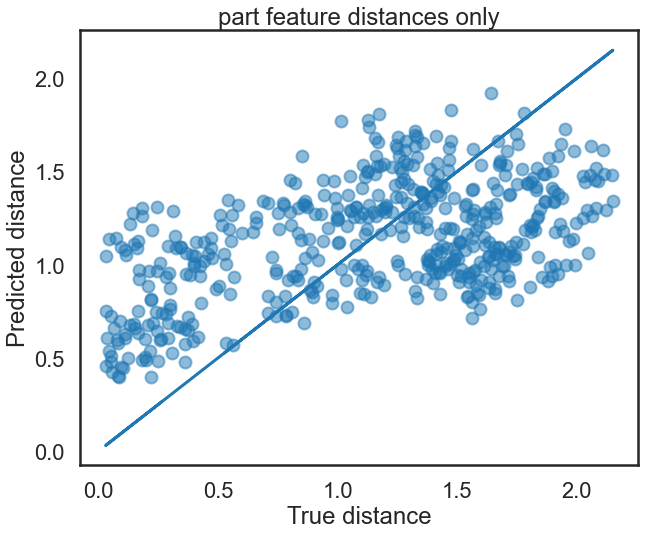

In [308]:
fig= plt.figure(figsize=(10,8))
#plot_cols=[col_dict[x] for x in fruit_names]
plt.title('part feature distances only')
plt.scatter(next_dist_f_mean, pred_part, alpha=0.5)
plt.plot(next_dist_f_mean,next_dist_f_mean)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
#plt.savefig('predict_vs_true_part.pdf', format='pdf')
plt.show()

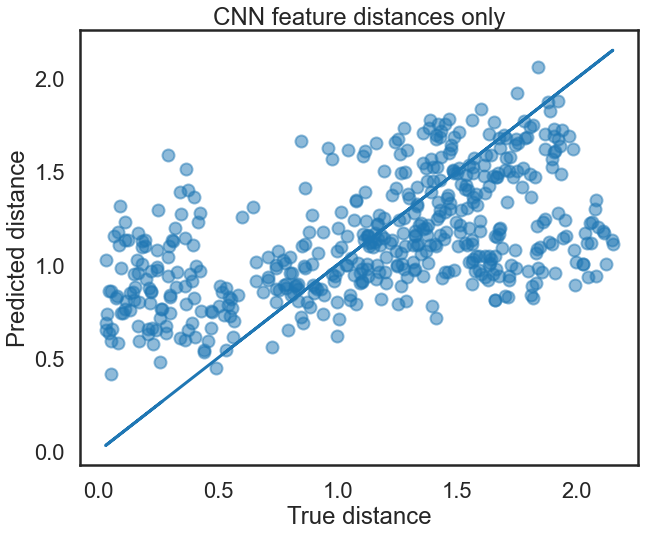

In [309]:
fig= plt.figure(figsize=(10,8))
plt.title('CNN feature distances only')
plt.scatter(next_dist_f_mean, pred_cnn, alpha=0.5)
plt.plot(next_dist_f_mean,next_dist_f_mean)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
#plt.savefig('predict_vs_true_cnn.pdf', format='pdf')
plt.show()

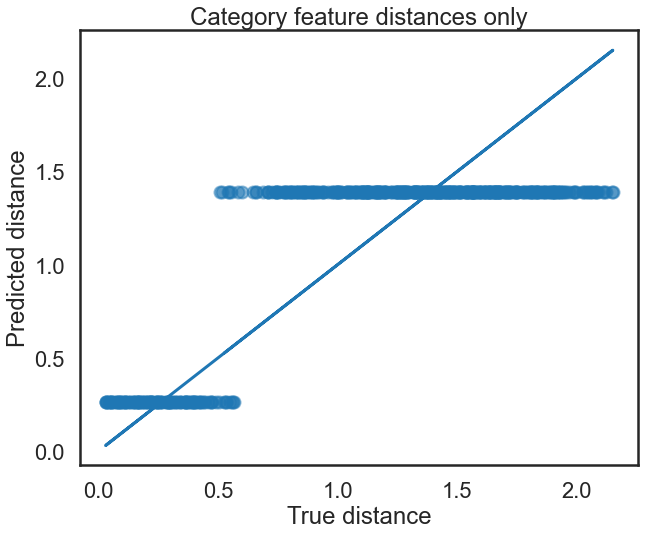

In [310]:
fig= plt.figure(figsize=(10,8))
#plot_cols=[col_dict[x] for x in fruit_names]
plt.title('Category feature distances only')
plt.scatter(next_dist_f_mean, pred_cat, alpha=0.5)
plt.plot(next_dist_f_mean,next_dist_f_mean)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
#plt.savefig('predict_vs_true_cnn.pdf', format='pdf')
plt.show()

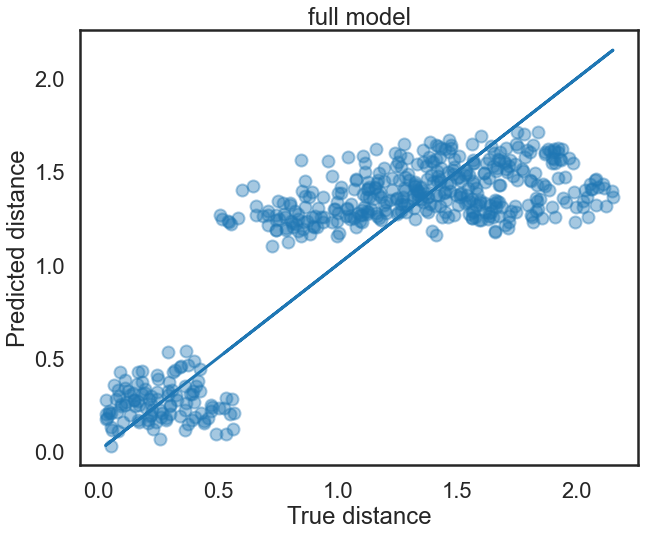

In [311]:
fig= plt.figure(figsize=(10,8))
#plot_cols=[col_dict[x] for x in fruit_names]
plt.title('full model')
plt.scatter(next_dist_f_mean, pred, alpha=0.4)
plt.plot(next_dist_f_mean,next_dist_f_mean)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
plt.savefig('predict_vs_true_full.pdf', format='pdf')
plt.show()

## Get feature distance matrices for all 128 sketches

In [576]:
#all_feats = all_feats.sort_values(by=['category_x','target_x']).reset_index()

next_dist_f = scipy.spatial.distance.pdist(all_feats[next_feat_cols], metric='euclidean')
next_dist_f = scipy.spatial.distance.squareform(next_dist_f)

cnn_dist_f = scipy.spatial.distance.pdist(all_feats[cnn_feat_cols], metric='euclidean')
cnn_dist_f = scipy.spatial.distance.squareform(cnn_dist_f)

part_dist_f = scipy.spatial.distance.pdist(all_feats[part_feat_cols], metric='euclidean')
part_dist_f =  scipy.spatial.distance.squareform(part_dist_f)

#sm_dist_f

tri_inds = np.tril_indices(next_dist_f.shape[0],-1)

#next_dist_f = next_dist_f[tri_inds]
#cnn_dist_f = cnn_dist_f[tri_inds]
#part_dist_f = part_dist_f[tri_inds]
#sm_dist_f = sm_dist_f[tri_inds]


## Scree plots for distance matrices

In [577]:
from sklearn.decomposition import PCA

Text(0.5, 1.0, 'VGG19 dissimilarity matrix singular values')

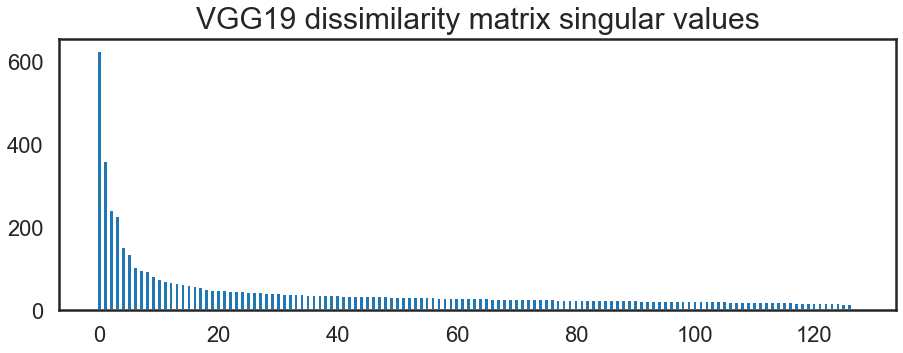

In [579]:
plt.figure(figsize = (15,5))
pca_cnn = PCA( svd_solver='full')
pca_cnn.fit(cnn_dist_f)
plt.bar(height=pca_cnn.singular_values_,x=np.arange(0,128))
pca_cnn.components_.shape
#plt.xticks(np.arange(0, 32, 2))
plt.title('VGG19 dissimilarity matrix singular values', fontsize=30,pad=10)

Text(0.5, 1.0, 'parts')

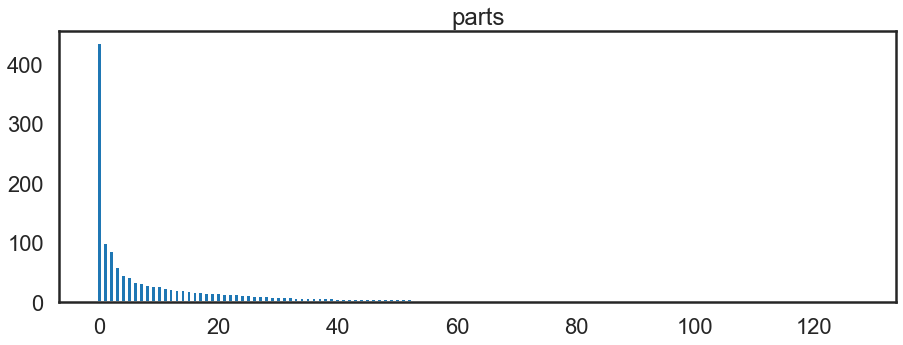

In [580]:
plt.figure(figsize = (15,5))
pca_parts = PCA( svd_solver='full')
pca_parts.fit(part_dist_f)
plt.bar(height = pca_parts.singular_values_, x=np.arange(0,128))
pca_parts.components_.shape
#plt.xticks(np.arange(0, 32, 2))
plt.title('parts')

Text(0.5, 1.0, 'next')

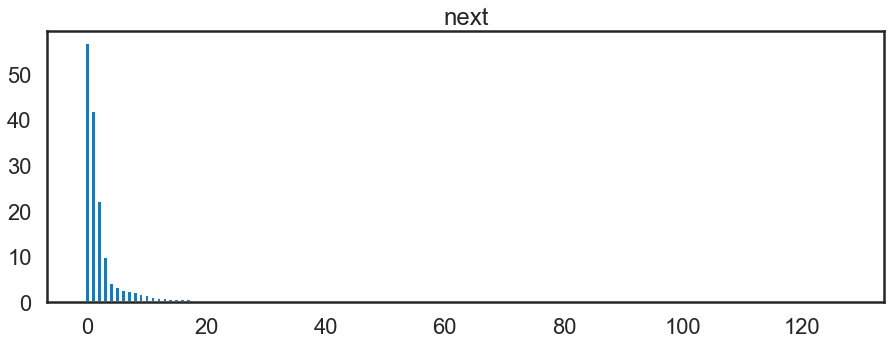

In [581]:
plt.figure(figsize = (15,5))
pca_next = PCA( svd_solver='full')
pca_next.fit(next_dist_f)
plt.bar(height = pca_next.singular_values_, x=np.arange(0,128))
pca_next.components_.shape
#plt.xticks(np.arange(0, 32, 2))
plt.title('next')

In [582]:
#all_feats = all_feats.sort_values(by=['category_x','target_x']).reset_index()

In [583]:
cat_dist_f = np.ones((128,128))
for i in range(all_feats.shape[0]):
    for j in range(all_feats.shape[0]):
        if all_feats.category_x[i] == all_feats.category_x[j]:
            cat_dist_f[i,j]=0


Text(0.5, 1.0, 'category')

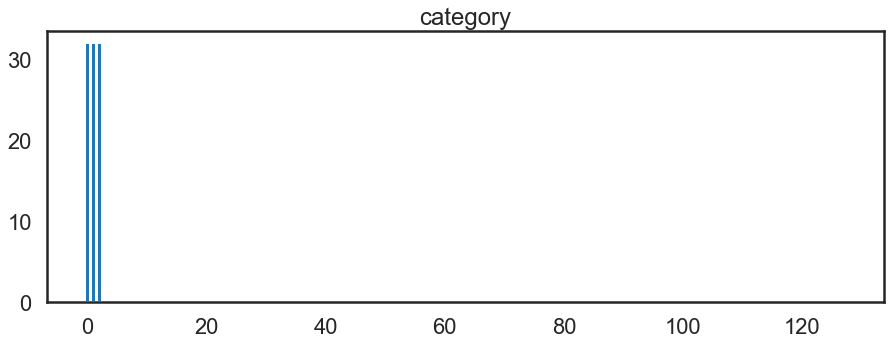

In [584]:
plt.figure(figsize = (15,5))
pca_cat = PCA( svd_solver='full')
pca_cat.fit(cat_dist_f)
plt.bar(height = pca_cat.singular_values_, x=np.arange(0,128))
pca_next.components_.shape
#plt.xticks(np.arange(0, 32, 2))
plt.title('category')

Text(0.5, 1.0, 'shape match')

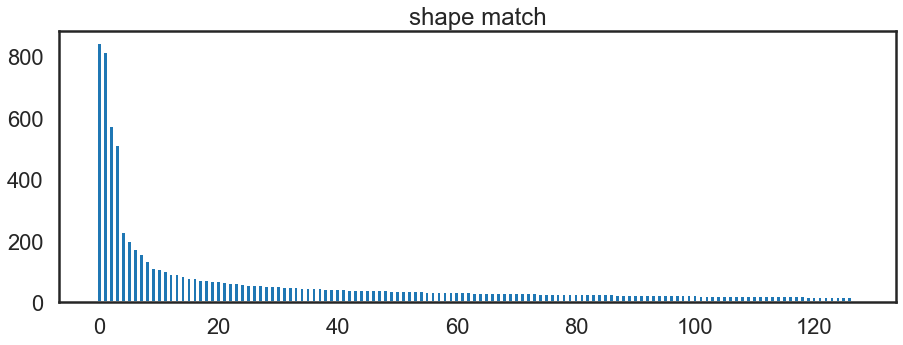

In [585]:
plt.figure(figsize = (15,5))
pca_sm = PCA( svd_solver='full')
pca_sm.fit(sm_dist_f)
plt.bar(height = pca_sm.singular_values_, x=np.arange(0,128))
#pca_next.components_.shape
#plt.xticks(np.arange(0, 32, 2))
plt.title('shape match')

In [586]:
##Do PCA and find optimal number of components
pca_cnn = PCA(n_components='mle', svd_solver='full')
pca_cnn.fit(cnn_dist_f)
pca_next = PCA( n_components='mle', svd_solver='full')
pca_next.fit(next_dist_f)
pca_parts = PCA( n_components='mle', svd_solver='full')
pca_parts.fit(part_dist_f)
pca_cat = PCA(n_components='mle',  svd_solver='full')
pca_cat.fit(cat_dist_f)
pca_sm = PCA( n_components='mle',  svd_solver='full')
pca_sm.fit(sm_dist_f)


PCA(n_components='mle', svd_solver='full')

In [587]:
print(pca_cnn.components_.shape[0], pca_parts.components_.shape[0], \
      pca_cat.components_.shape[0], pca_next.components_.shape[0],pca_sm.components_.shape[0])


127 34 3 40 15


In [648]:
y_1= all_feats.coord_1
y_2= all_feats.coord_2

In [478]:
### Predict first 3 components
y_1 = pca_next.components_[0]
y_2 = pca_next.components_[1]
y_3 = pca_next.components_[2]

In [649]:
Z = np.vstack([pca_parts.components_[0:3],pca_sm.components_[0:3],pca_cat.components_[0:3]]).T

X = np.vstack([pca_cnn.components_[0:3], pca_parts.components_[0:3],pca_sm.components_[0:3],pca_cat.components_[0:3]]).T


In [651]:
_X = sm.add_constant(X)
_Z = sm.add_constant(Z)
model_c1 = sm.OLS(y_1, _X).fit()
model_c1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                coord_1   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     42.61
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.17e-36
Time:                        11:05:39   Log-Likelihood:                -23.779
No. Observations:                 128   AIC:                             73.56
Df Residuals:                     115   BIC:                             110.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2224      0.168     -1.323      0.189      -0.555       0.111
x1             2.9381      1.019      2.883      0.005       0.919       4.957
x2             1.8155      0.453      4.008      0.000       0.918       2.713
x3            -0.0250      0.687     -0.036      0.971      -1.385       1.335
x4             0.4839      1.373      0.353      0.725      -2.235       3.203
x5             1.8374      1.012      1.816      0.072      -0.167       3.841
x6            -0.0239      0.659     -0.036      0.971      -1.328       1.281
x7            -1.2386      0.676     -1.832      0.070      -2.578       0.101
x8            -0.9228      0.945     -0.976      0.331      -2.795       0.949
x9            -0.6895      0.482     -1.431      0.155      -1.644       0.265
x10           -1.9870      0.653     -3.041      0.003      -3.281      -0.693
x11           -3.2115      0.577     -5.566      0.000      -4.354      -2.069
x12            2.2727      1.050      2.164      0.033       0.192       4.353
==============================================================================
Omnibus:                       46.369   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.048
Skew:                          -1.266   Prob(JB):                     2.38e-36
Kurtosis:                       7.934   Cond. No.                         57.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [619]:
model_c1_sub = sm.OLS(y_1, _Z).fit()
model_c1_sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     126.0
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           3.34e-56
Time:                        04:22:03   Log-Likelihood:                 280.78
No. Observations:                 128   AIC:                            -541.6
Df Residuals:                     118   BIC:                            -513.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0187      0.014      1.304      0.195      -0.010       0.047
x1             0.0766      0.119      0.645      0.520      -0.159       0.312
x2             0.1225      0.091      1.349      0.180      -0.057       0.302
x3             0.1016      0.059      1.711      0.090      -0.016       0.219
x4            -0.0475      0.062     -0.772      0.442      -0.169       0.074
x5            -0.1760      0.085     -2.070      0.041      -0.344      -0.008
x6            -0.1092      0.044     -2.498      0.014      -0.196      -0.023
x7            -0.5736      0.059     -9.736      0.000      -0.690      -0.457
x8            -0.4944      0.053     -9.401      0.000      -0.599      -0.390
x9             0.2231      0.085      2.623      0.010       0.055       0.391
==============================================================================
Omnibus:                       49.723   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.995
Skew:                          -1.341   Prob(JB):                     9.13e-42
Kurtosis:                       8.314   Cond. No.                         54.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

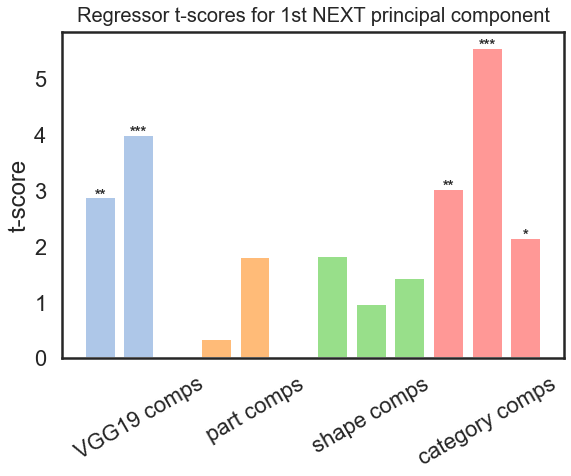

In [652]:

from itertools import repeat

plt.figure(figsize=(9,6))
t_cmap = plt.get_cmap("tab20")

l = [list((t_cmap.colors[1],)*3),list((t_cmap.colors[3],)*3),list((t_cmap.colors[5],)*3),list((t_cmap.colors[7],)*3)]
t_colors = [item for sublist in l for item in sublist]




bar = plt.bar(np.arange(len(model_c1.tvalues[1:])),np.abs(model_c1.tvalues[1:]),color=t_colors)

for i,rect in enumerate(bar):
    if model_c1.pvalues[i+1]<0.001:
        annot = '***'
    elif model_c1.pvalues[i+1]<0.01:
        annot = '**'
    elif model_c1.pvalues[i+1]<0.05:
        annot = '*'
    else:
        annot=''
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height-0.10, f'{annot}', ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.xticks(np.arange(1,12,3),['VGG19 comps','part comps','shape comps','category comps'], rotation=30)
plt.ylabel('t-score')
plt.xlabel('')
plt.title('Regressor t-scores for 1st NEXT principal component', fontsize=20,pad=10)
plt.savefig('reg1.pdf',bbox_inches='tight')

In [653]:
_X = sm.add_constant(X)
model_c2 = sm.OLS(y_2, _X).fit()
model_c2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                coord_2   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     71.24
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.06e-47
Time:                        11:06:02   Log-Likelihood:                 5.0637
No. Observations:                 128   AIC:                             15.87
Df Residuals:                     115   BIC:                             52.95
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2046      0.134     -1.525      0.130      -0.470       0.061
x1             0.5393      0.814      0.663      0.509      -1.072       2.151
x2             0.1644      0.362      0.455      0.650      -0.552       0.881
x3             0.2164      0.548      0.395      0.694      -0.869       1.302
x4             0.7937      1.096      0.724      0.470      -1.377       2.964
x5             0.0964      0.808      0.119      0.905      -1.503       1.696
x6            -1.5195      0.526     -2.890      0.005      -2.561      -0.478
x7            -0.5441      0.540     -1.008      0.316      -1.613       0.525
x8             0.7857      0.754      1.041      0.300      -0.709       2.280
x9             0.3070      0.385      0.798      0.426      -0.455       1.069
x10            4.2859      0.522      8.216      0.000       3.253       5.319
x11            2.3871      0.461      5.183      0.000       1.475       3.299
x12            2.5193      0.838      3.005      0.003       0.858       4.180
==============================================================================
Omnibus:                        2.513   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.381
Skew:                          -0.333   Prob(JB):                        0.304
Kurtosis:                       2.936   Cond. No.                         57.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

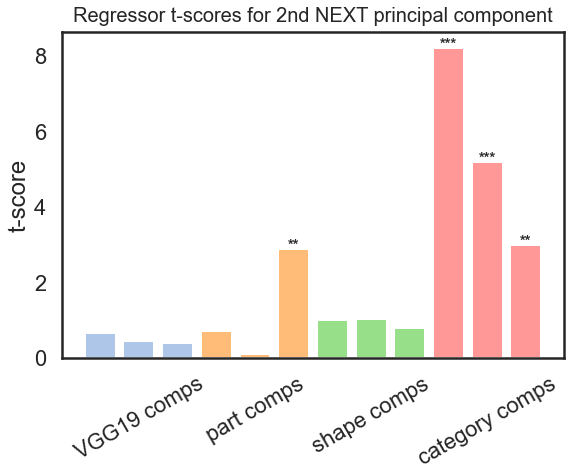

In [654]:
plt.figure(figsize=(9,6))
bar = plt.bar(np.arange(len(model_c2.tvalues[1:])),np.abs(model_c2.tvalues[1:]),color=t_colors)

for i,rect in enumerate(bar):
    if model_c2.pvalues[i+1]<0.001:
        annot = '***'
    elif model_c2.pvalues[i+1]<0.01:
        annot = '**'
    elif model_c2.pvalues[i+1]<0.05:
        annot = '*'
    else:
        annot=''
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height-0.10, f'{annot}', ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.xticks(np.arange(1,12,3),['VGG19 comps','part comps','shape comps','category comps'], rotation=30)
plt.ylabel('t-score')
plt.xlabel('')
plt.title('Regressor t-scores for 2nd NEXT principal component', fontsize=20,pad=10)
plt.savefig('reg2.pdf',bbox_inches='tight')


In [484]:
_X = sm.add_constant(X)
model_c3 = sm.OLS(y_3, _X).fit()

model_c3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     10.49
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           9.91e-14
Time:                        00:17:53   Log-Likelihood:                 303.16
No. Observations:                 128   AIC:                            -580.3
Df Residuals:                     115   BIC:                            -543.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0614      0.013      4.698      0.000       0.036       0.087
x1             0.0103      0.079      0.130      0.897      -0.147       0.167
x2             0.0398      0.035      1.129      0.261      -0.030       0.110
x3             0.0643      0.053      1.204      0.231      -0.042       0.170
x4             0.1182      0.107      1.107      0.271      -0.093       0.330
x5            -0.1514      0.079     -1.925      0.057      -0.307       0.004
x6             0.0399      0.051      0.780      0.437      -0.062       0.141
x7             0.0129      0.053      0.246      0.806      -0.091       0.117
x8             0.1102      0.073      1.499      0.137      -0.035       0.256
x9             0.0246      0.037      0.657      0.512      -0.050       0.099
x10            0.1632      0.051      3.212      0.002       0.063       0.264
x11           -0.0650      0.045     -1.449      0.150      -0.154       0.024
x12            0.0900      0.082      1.102      0.273      -0.072       0.252
==============================================================================
Omnibus:                        1.577   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.285
Skew:                          -0.000   Prob(JB):                        0.526
Kurtosis:                       2.509   Cond. No.                         57.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [656]:
##PREDICTIONS
c1_preds =model_c1.predict().reshape(128,1)
c2_preds =model_c2.predict().reshape(128,1)
#c3_preds =model_c3.predict().reshape(128,1)


# coord_preds = np.hstack([c1_preds, c2_preds, c3_preds])
coord_preds = np.hstack([c1_preds, c2_preds])

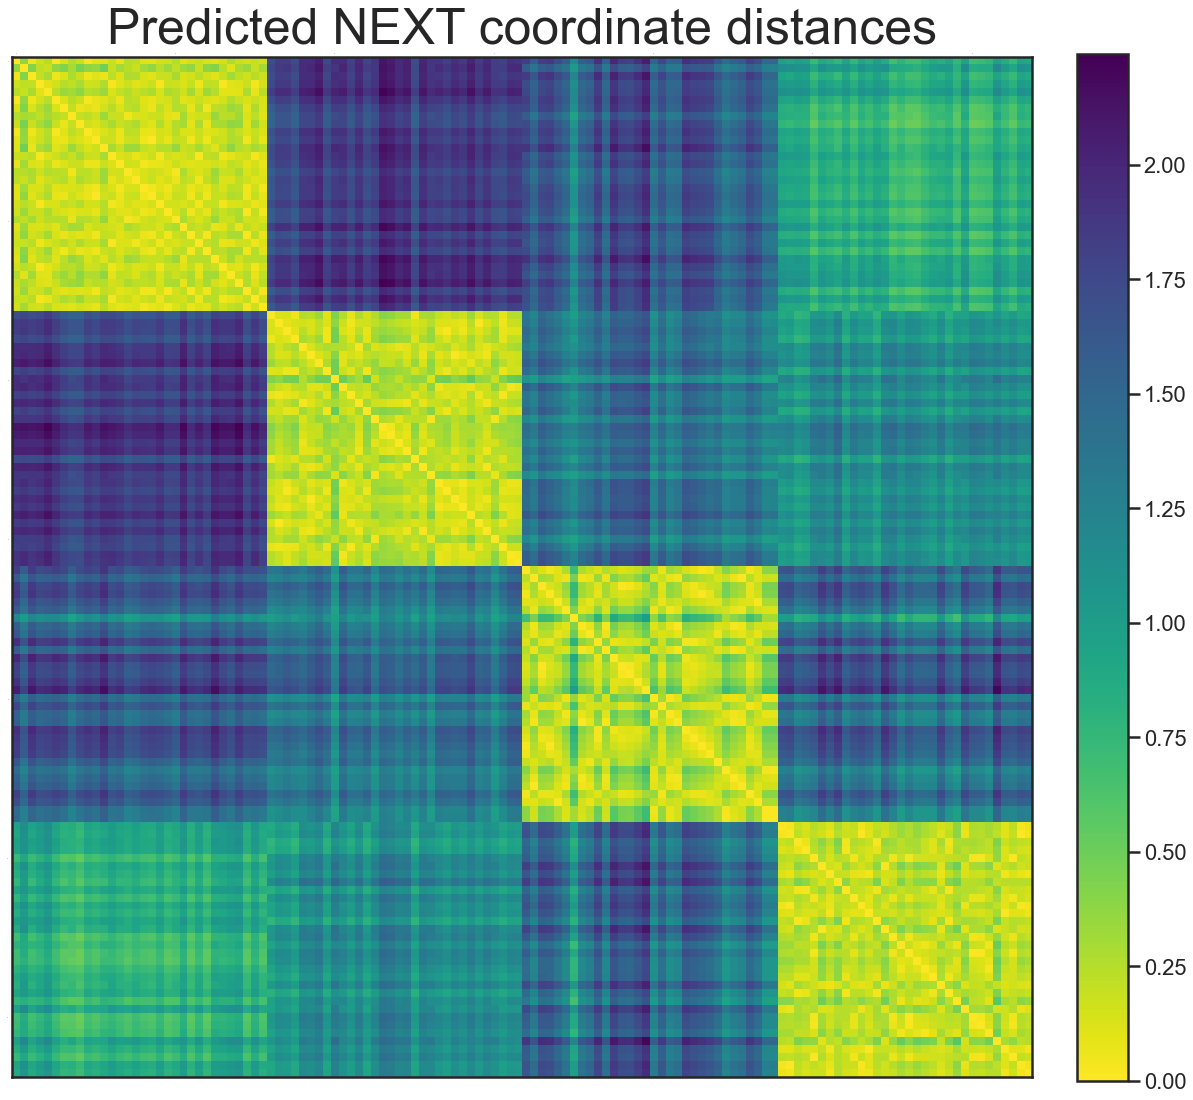

In [657]:
coord_dmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(coord_preds, metric='euclidean'))
plt.figure(figsize=(20,20))
plt.matshow(coord_dmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
# plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Predicted NEXT coordinate distances',fontsize=50)
plt.show()

In [569]:
from tqdm import tqdm, trange

sm_dist_f = np.zeros((128,128))
for i in trange(all_feats.shape[0],position=0, leave=True):
    for j in trange(all_feats.shape[0],position=0, leave=True):
        p1 = cv2.imread(f"../plots/triplet_sketches_png/{all_feats.sketch_id[i]}.png")
        p2 = cv2.imread(f"../plots/triplet_sketches_png/{all_feats.sketch_id[j]}.png")
        #get_diff
        sm_dist_f[i,j] = get_diff(p1,p2)
        

  0%|          | 0/128 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [387]:

        
# with open('../sm_dists.npy', 'wb') as f:
#     np.save(f, sm_dist_f)

## RSA?

In [602]:

next_dist_tri = next_dist_f[tri_inds]
cnn_dist_tri = cnn_dist_f[tri_inds]
part_dist_tri = part_dist_f[tri_inds]
sm_dist_tri = sm_dist_f[tri_inds]
cat_dist_tri = cat_dist_f[tri_inds]

In [603]:
print('CNN Corr')
cnn_cor = np.corrcoef(next_dist_tri,cnn_dist_tri)[0,1]

CNN Corr


In [604]:
print('Part Corr')
part_cor = np.corrcoef(next_dist_tri,part_dist_tri)[0,1]

Part Corr


In [605]:
print('Shape match Corr')
shape_cor = np.corrcoef(next_dist_tri,sm_dist_tri)[0,1]

Shape match Corr


In [606]:
print('Cat match Corr')
cat_cor = np.corrcoef(next_dist_tri,cat_dist_tri)[0,1]

Cat match Corr


(0.0, 1.0)

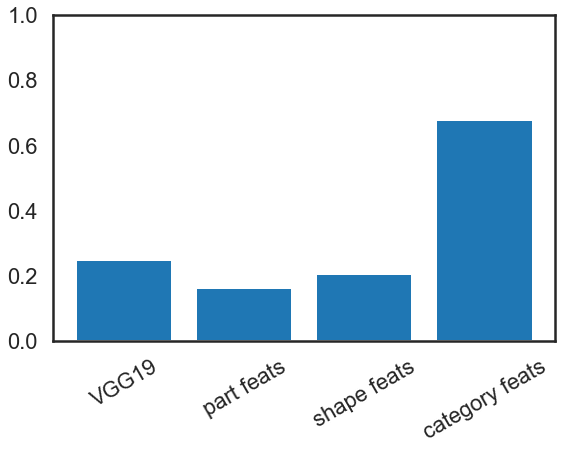

In [607]:
plt.figure(figsize=(9,6))
plt.bar(np.arange(0,4),[cnn_cor, part_cor, shape_cor, cat_cor])
plt.xticks(np.arange(0,4),['VGG19','part feats','shape feats','category feats'], rotation=30)
plt.ylim(0,1)

## Predicting Judgements

In [686]:
results = score(feats_df1, progress_full, cnn_feat_cols)
results_parts = score(all_feats, progress_full, part_feat_cols)
results_cats = score(all_feats, progress_full, part_feat_cols, distmat=cat_dist_f)
results_sm = score(all_feats, progress_full, part_feat_cols, distmat=sm_dist_f)
results_coords = score(all_feats, progress_full,part_feat_cols, distmat = coord_dmat)

print(f'CNN predictions  = {np.mean(results) }')
print(f'Part based predictions = {np.mean(results_parts)}')
print(f'Category based predictions = {np.mean(results_cats)}')
print(f'Shape match based predictions = {np.mean(results_sm)}')
print(f'coordinate based predictions = {np.mean(results_coords)}')

CNN predictions  = 0.5914482758620689
Part based predictions = 0.6201379310344828
Category based predictions = 0.654896551724138
Shape match based predictions = 0.5762758620689655
coordinate based predictions = 0.7464827586206897


In [718]:
cnn_sem = 1.96*np.sqrt(np.mean(results)*(1-np.mean(results))/len(results))
part_sem = 1.96*np.sqrt(np.mean(results_parts)*(1-np.mean(results_parts))/len(results))
cat_sem = 1.96*np.sqrt(np.mean(results_cats)*(1-np.mean(results_cats))/len(results))
sm_sem = 1.96*np.sqrt(np.mean(results_sm)*(1-np.mean(results_sm))/len(results))
pred_sem = 1.96*np.sqrt(np.mean(results_coords)*(1-np.mean(results_coords))/len(results))


(0.5, 1.0)

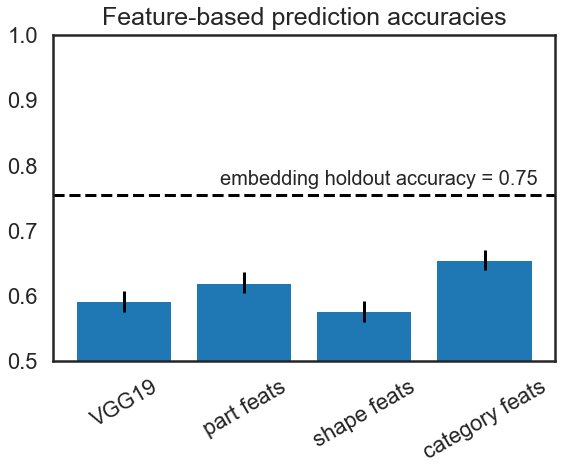

In [719]:
plt.figure(figsize=(9,6))
plt.bar(np.arange(0,4),[np.mean(results), np.mean(results_parts),\
                        np.mean(results_sm), np.mean(results_cats)])
plt.xticks(np.arange(0,4),['VGG19','part feats','shape feats','category feats'], rotation=30)
plt.errorbar(np.arange(0,4),[np.mean(results), np.mean(results_parts),\
                        np.mean(results_sm), np.mean(results_cats)], yerr = [cnn_sem,part_sem,sm_sem, cat_sem], color='k',ls='none')
plt.axhline(y=.75414,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.75', fontsize=20)
plt.title('Feature-based prediction accuracies', fontsize=25, pad=10)
plt.ylim(0.5,1)

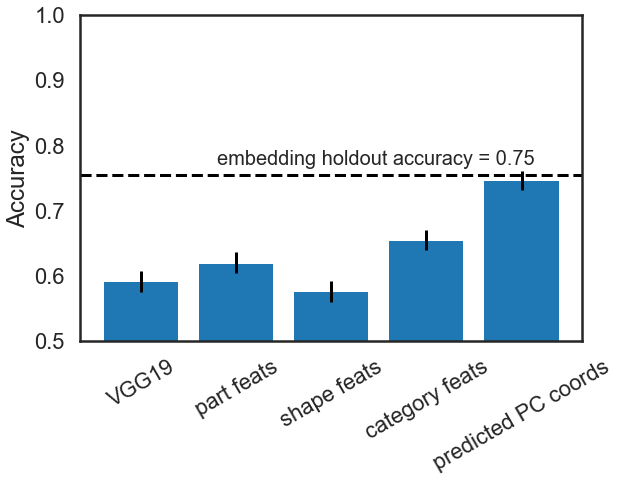

In [726]:
plt.figure(figsize=(9,6))
plt.bar(np.arange(0,5),[np.mean(results), np.mean(results_parts),\
                        np.mean(results_sm), np.mean(results_cats),np.mean(results_coords)])
plt.axhline(y=.75414,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.75', fontsize=20)
plt.xticks(np.arange(0,5),['VGG19','part feats','shape feats','category feats','predicted PC coords'], rotation=30)
plt.errorbar(np.arange(0,5),[np.mean(results), np.mean(results_parts),\
                        np.mean(results_sm), np.mean(results_cats),np.mean(results_coords)], yerr = [cnn_sem,part_sem,sm_sem, cat_sem,pred_sem], color='k',ls='none')
plt.ylim(0.5,1)
plt.ylabel('Accuracy')
plt.savefig('accuracy.pdf',bbox_inches='tight')

In [643]:
np.mean(results_coords)

0.7451034482758621

### Tests

In [555]:
im1 = cv2.imread('../plots/triplet_sketches_png/0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11.png')
im2 = cv2.imread('../plots/triplet_sketches_png/0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15.png')
im3 = cv2.imread('../plots/triplet_sketches_png/7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_6.png')
im4 = cv2.imread('../plots/triplet_sketches_png/8265-92081336-152b-4a90-bdb4-fea038f4c9b8_18.png')
import time

In [ ]:
start = time.time()
for i in range(20):
    get_diff(im1,im2)
end = time.time()

print((end-start)/20)

Cosine diff: 0.6549449372172762
Standard diff: 72.20504103200253


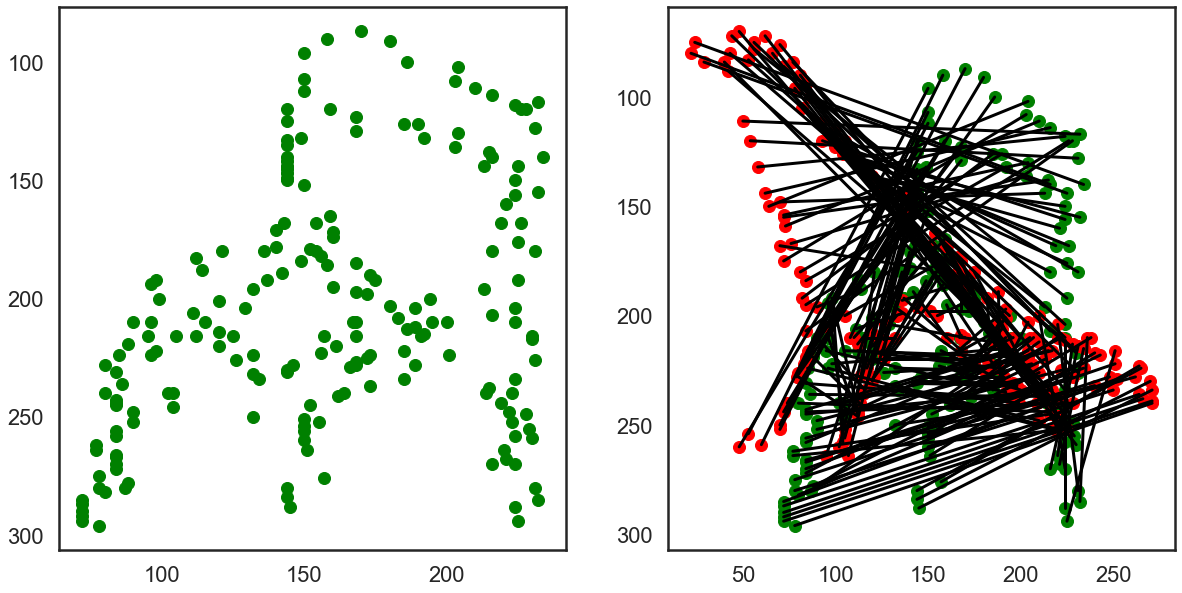

In [556]:
sc_plot(im3,im4)

Cosine diff: 0.6228848153478255
Standard diff: 40.43877641551647


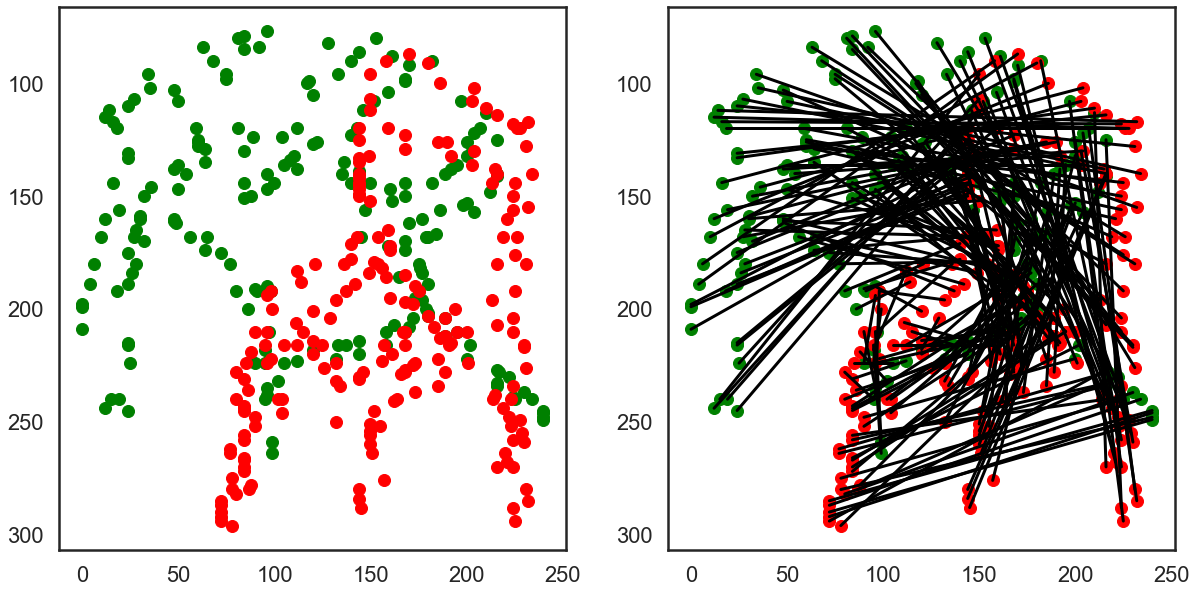

In [255]:
sc_plot(im1,im3)

Cosine diff: 0.4911704483241498
Standard diff: 56.517175141130465


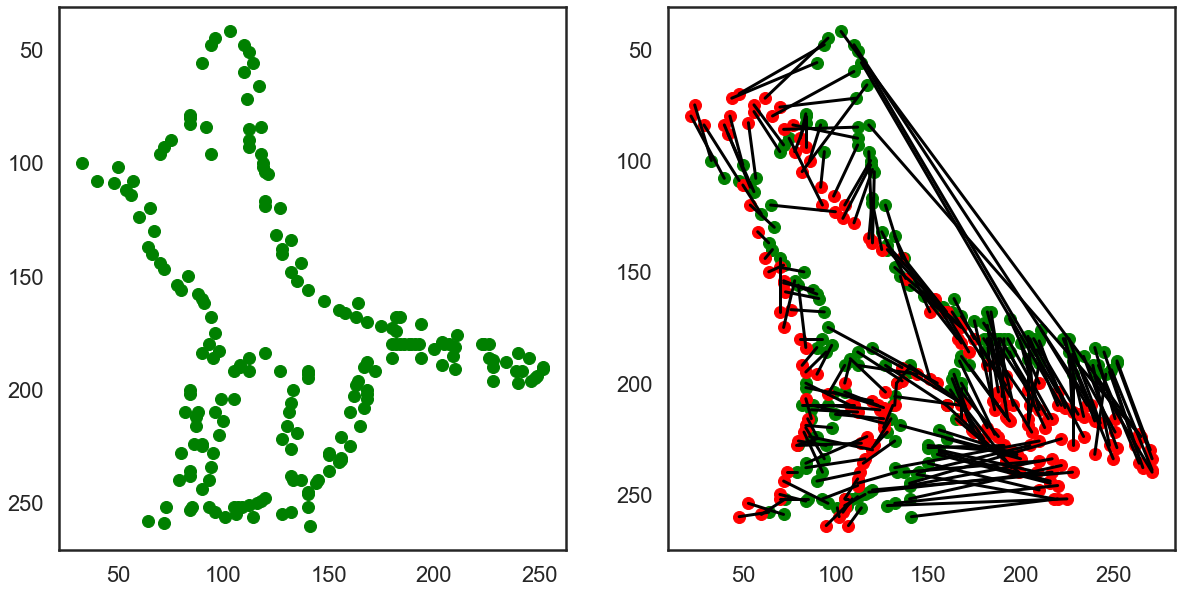

In [557]:
sc_plot(im2,im4)

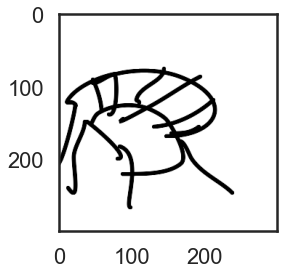

In [257]:
plt.imshow(im1)

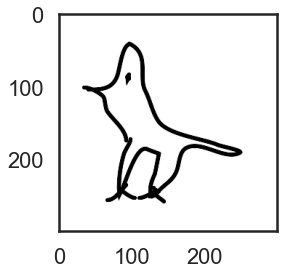

In [641]:
plt.imshow(im2)
plt.savefig('ex1.pdf', format='pdf', bbox_inches='tight')

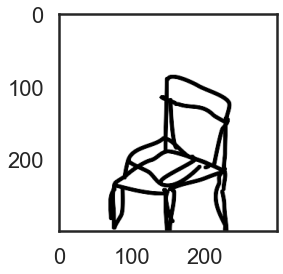

In [259]:
plt.imshow(im3)

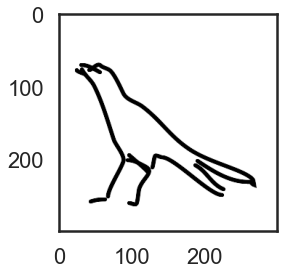

In [642]:
plt.imshow(im4)
plt.savefig('ex2.pdf', format='pdf', bbox_inches='tight')

In [261]:
px,py,pz =np.gradient(im4)

In [262]:
py.shape[0]

300

In [263]:
np.gradient(np.array([0,0,1,0,0]))

array([ 0. ,  0.5,  0. , -0.5,  0. ])

In [ ]:
sc= ShapeContext()
sc.compute(sc.get_points_from_img(im1,simpleto=200)[0]).shape

## EMD stuff


In [ ]:
a = [0,1,2,3,1,4,5,2,0]

In [ ]:
b = filter(lambda x: x>0,[4,0,1,2,3])

In [ ]:
if any(b):
    print(list(b))

In [ ]:
print(list(b))

In [ ]:
from matplotlib import image


In [ ]:
s1 = np.asarray(Image.open('s1.png').convert('1'))


In [ ]:
plt.imshow(s1)

In [ ]:
s1.shape

In [ ]:
s1[299,299,:]

In [ ]:
s1_2d = np.max(s1[:,:,0:3], axis=2)


In [ ]:
plt.imshow(s1_2d)

In [ ]:
with np.printoptions(threshold=np.inf):
    print(s1)

In [ ]:
_s1 = 1-s1

In [ ]:
plt.imshow(_s1)
_s1_arr = np.array(_s1)
plt.imsave('check_0.png',_s1_arr)

In [ ]:
s1 = np.array(Image.open('s1.png').convert('1'))
s2 = np.array(Image.open('s2.png').convert('1'))
s3 = np.array(Image.open('s3.png').convert('1'))
s4 = np.array(Image.open('s4.png').convert('1'))

In [ ]:
plt.imshow(s1)

In [ ]:
plt.imshow(s2)

In [ ]:
plt.imshow(s3)

In [ ]:
plt.imshow(s4)

In [ ]:
from scipy.stats import wasserstein_distance

wasserstein_distance(s1.flatten(), s2.flatten())

In [ ]:
wasserstein_distance(s2.flatten(), s3.flatten())

In [ ]:
wasserstein_distance(s1.flatten(), s3.flatten())

In [ ]:
wasserstein_distance(s3.flatten(), s4.flatten())